## 1. Data Collection, Cleaning and Preparation

#### importing necessary libraries

In [692]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import seaborn as sns

#### Loading the Data

In [693]:
url1 = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_train.csv"
# url2 = "https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/home_loan_test.csv"

In [694]:
df = pd.read_csv(url1)
# data2 = pd.read_csv(url2)

## Preliminary Data Analysis

In [695]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [696]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [697]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

In [698]:
print(len(df))
# print(len(data2))
# print(len(dataset))



614


In [699]:
df.shape

(614, 13)

In [700]:
missing_total = df.isna().sum()
missing_total

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [701]:
missing_total.sum()

np.int64(149)

In [702]:
len(df)

614

## Data Cleaning

In [703]:
df[df["Married"].isna()]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
104,LP001357,Male,NaN,NaN,Graduate,No,3816,754.0,160.0,360.0,1.0,Urban,Y
228,LP001760,Male,NaN,NaN,Graduate,No,4758,0.0,158.0,480.0,1.0,Semiurban,Y
435,LP002393,Female,NaN,NaN,Graduate,No,10047,0.0,NaN,240.0,1.0,Semiurban,Y


In [704]:
# Drop missingness where minimal

df.dropna(subset=["Married"], inplace=True)
df.dropna(subset=["Loan_Amount_Term"], inplace=True)
df.dropna(subset=["Gender"], inplace=True)
df.dropna(subset=["Dependents"], inplace=True)


In [705]:
df.isna().sum()

Loan_ID               0
Gender                0
Married               0
Dependents            0
Education             0
Self_Employed        31
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term      0
Credit_History       49
Property_Area         0
Loan_Status           0
dtype: int64

#### Outlier-Handling Pipeline

In [706]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
numeric_cols

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

- revealing outliers by skewness

In [707]:
for col in numeric_cols:
    print(f'{col} = "{df[col].skew():.3f}" skewness value')

ApplicantIncome = "6.868" skewness value
CoapplicantIncome = "7.421" skewness value
LoanAmount = "2.486" skewness value
Loan_Amount_Term = "-2.425" skewness value
Credit_History = "-2.044" skewness value


In [708]:
def handle_outliers(df, skew_threshold=1.0):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns

    for col in numeric_cols:
        # Skip binary or constant columns
        if df[col].nunique() <= 2:
            continue

        # IQR capping (outlier handling)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))

        # Check skew
        skew = df[col].skew()

        # Apply transformations
        if skew > skew_threshold:
            # Positive skew → log transform
            df[col] = np.log1p(df[col] - df[col].min() + 1)

        elif skew < -skew_threshold:
            # Negative skew → reflect + log
            max_val = df[col].max()
            df[col] = np.log1p(max_val - df[col] + 1)

    return df


In [709]:
clean_df = handle_outliers(df)

In [710]:
numeric_cols = clean_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    print(f'{col} = "{clean_df[col].skew():.3f}" skewness value')

ApplicantIncome = "-3.258" skewness value
CoapplicantIncome = "-0.182" skewness value
LoanAmount = "0.747" skewness value
Loan_Amount_Term = "0.000" skewness value
Credit_History = "-2.044" skewness value


In [711]:
df = clean_df.copy()

In [712]:
# Replace other missing fields with proper means

df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)

df["Self_Employed"].fillna(df["Self_Employed"].mode()[0], inplace=True)

df["Credit_History"].fillna(df["Credit_History"].median(), inplace=True)

df['Dependents'] = df['Dependents'].replace("3+", 3).astype(int)


C:\Users\USER\AppData\Local\Temp\ipykernel_17788\1149166029.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["LoanAmount"].fillna(df["LoanAmount"].mean(), inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_17788\1149166029.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [713]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

- now our data appears to be free of missingness at this point

## Exploratory Data Analysis

### Descriptive Data Summary

In [714]:
df.head(20)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,8.648397,0.693147,138.629295,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,8.397283,7.319865,128.000000,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,7.955776,0.693147,66.000000,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,7.797702,7.766417,120.000000,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,8.674539,0.693147,141.000000,360.0,1.0,Urban,Y
5,LP001011,Male,Yes,2,Graduate,Yes,8.569596,8.342364,267.000000,360.0,1.0,Urban,Y
6,LP001013,Male,Yes,0,Not Graduate,No,7.689371,7.325149,95.000000,360.0,1.0,Urban,Y
7,LP001014,Male,Yes,3,Graduate,No,7.968320,7.826443,158.000000,360.0,0.0,Semiurban,N
8,LP001018,Male,Yes,2,Graduate,No,8.257904,7.331715,168.000000,360.0,1.0,Urban,Y
9,LP001020,Male,Yes,1,Graduate,No,9.217862,8.658172,275.000000,360.0,1.0,Semiurban,N


In [715]:
df.shape

(573, 13)

In [716]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 573 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            573 non-null    object 
 1   Gender             573 non-null    object 
 2   Married            573 non-null    object 
 3   Dependents         573 non-null    int64  
 4   Education          573 non-null    object 
 5   Self_Employed      573 non-null    object 
 6   ApplicantIncome    573 non-null    float64
 7   CoapplicantIncome  573 non-null    float64
 8   LoanAmount         573 non-null    float64
 9   Loan_Amount_Term   573 non-null    float64
 10  Credit_History     573 non-null    float64
 11  Property_Area      573 non-null    object 
 12  Loan_Status        573 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 62.7+ KB


In [717]:
df.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,573.000000,573.000000,573.000000,573.000000,573.0,573.000000
mean,0.766143,8.243379,4.590154,138.629295,360.0,0.869110
std,1.009278,0.645978,3.511349,58.322515,0.0,0.337575
min,0.000000,0.693147,0.693147,9.000000,360.0,0.000000
25%,0.000000,7.911324,0.693147,100.000000,360.0,1.000000
50%,0.000000,8.206311,7.100027,129.000000,360.0,1.000000
75%,2.000000,8.642415,7.742402,165.000000,360.0,1.000000
max,3.000000,9.217862,8.658172,275.000000,360.0,1.000000


In [718]:
df.nunique()

Loan_ID              573
Gender                 2
Married                2
Dependents             4
Education              2
Self_Employed          2
ApplicantIncome      426
CoapplicantIncome    258
LoanAmount           170
Loan_Amount_Term       1
Credit_History         2
Property_Area          3
Loan_Status            2
dtype: int64

## Exploratory Data Analysis


In [719]:
average_income = df["ApplicantIncome"].mean()

high_income = df[df["ApplicantIncome"] > average_income]
lesser_income = df[df["ApplicantIncome"] < average_income]


def get_income_rating(x):
    if x> average_income:
        return ("High")
    else:
        return ("Low")


df["income_rating"] = df["ApplicantIncome"].apply(get_income_rating)

In [720]:
num_features = df.select_dtypes(include=["number"])
num_features.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,0,8.648397,0.693147,138.629295,360.0,1.0
1,1,8.397283,7.319865,128.000000,360.0,1.0
2,0,7.955776,0.693147,66.000000,360.0,1.0
3,0,7.797702,7.766417,120.000000,360.0,1.0
4,0,8.674539,0.693147,141.000000,360.0,1.0


In [721]:
cat_features = df.drop(columns=num_features)
cat_features = cat_features.drop(columns=["Loan_ID"])
cat_features.head()

,Gender,Married,Education,Self_Employed,Property_Area,Loan_Status,income_rating
0,Male,No,Graduate,No,Urban,Y,High
1,Male,Yes,Graduate,No,Rural,N,High
2,Male,Yes,Graduate,Yes,Urban,Y,Low
3,Male,Yes,Not Graduate,No,Urban,Y,Low
4,Male,No,Graduate,No,Urban,Y,High


## Univariate Analysis

In [722]:
def num_univariate_analysis(df, feature):
    skewness = df[feature].skew()
    kurtosis = df[feature].kurt()

    print("--"*40)
    print(f"\n Analysis for {feature}")
    print("=="*40)
    


    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True, color="blueviolet")
    plt.title(f"\nHistplot analysis for {feature}\n")
    plt.xlabel(f"\n{feature}\n")
    plt.ylabel(f"\nFrequency\n")


    plt.subplot(1, 2, 2)
    sns.boxplot(df[feature], color="blueviolet")
    plt.title(f"\n Boxplot for {feature}\n")
    plt.xlabel(f"\n{feature}\n")
    plt.ylabel(f"\nFrequency\n")

    plt.tight_layout()
    plt.show()


    print(f"{feature} feature skewness: {skewness:.3f}")
    print(f"{feature} feature kurtosis: {kurtosis:.3f}")

    if skewness > 1:
        print(f"{feature} values set are highly skewed")
    elif skewness > 0.5:
        print(f"{feature} values set are Moderately skewed")
    else :
        print(f"{feature} values set are Slightly skewed\n")

--------------------------------------------------------------------------------

 Analysis for Dependents


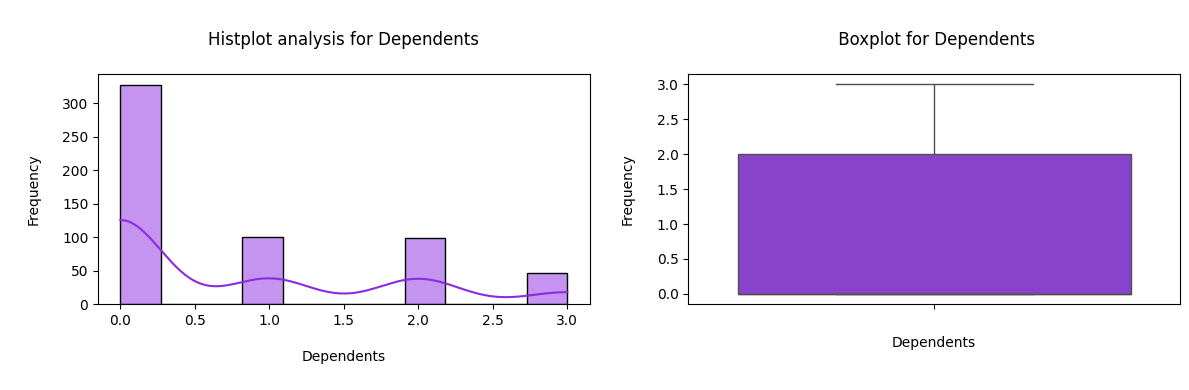

Dependents feature skewness: 0.963
Dependents feature kurtosis: -0.440
Dependents values set are Moderately skewed
--------------------------------------------------------------------------------

 Analysis for ApplicantIncome


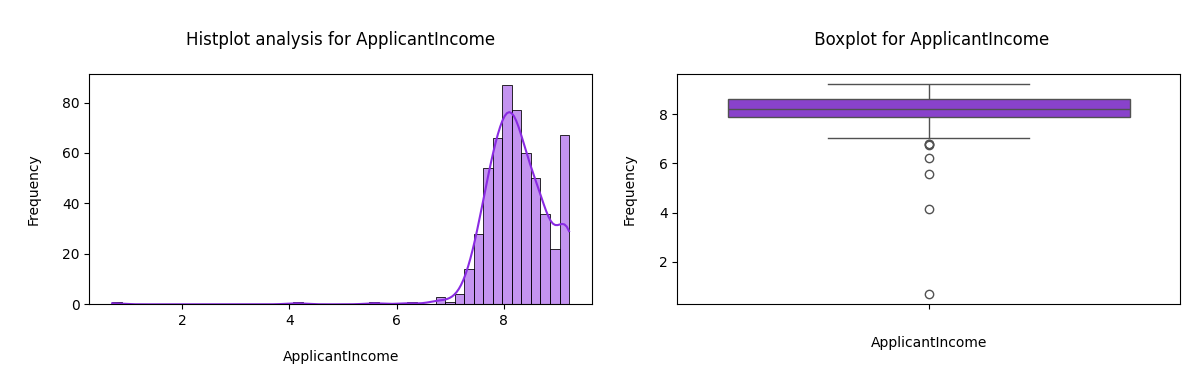

ApplicantIncome feature skewness: -3.258
ApplicantIncome feature kurtosis: 34.621
ApplicantIncome values set are Slightly skewed

--------------------------------------------------------------------------------

 Analysis for CoapplicantIncome


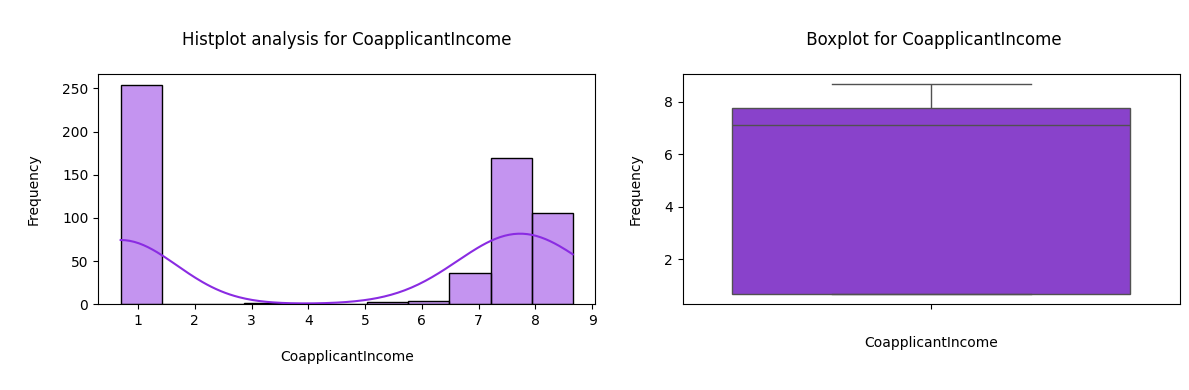

CoapplicantIncome feature skewness: -0.182
CoapplicantIncome feature kurtosis: -1.921
CoapplicantIncome values set are Slightly skewed

--------------------------------------------------------------------------------

 Analysis for LoanAmount


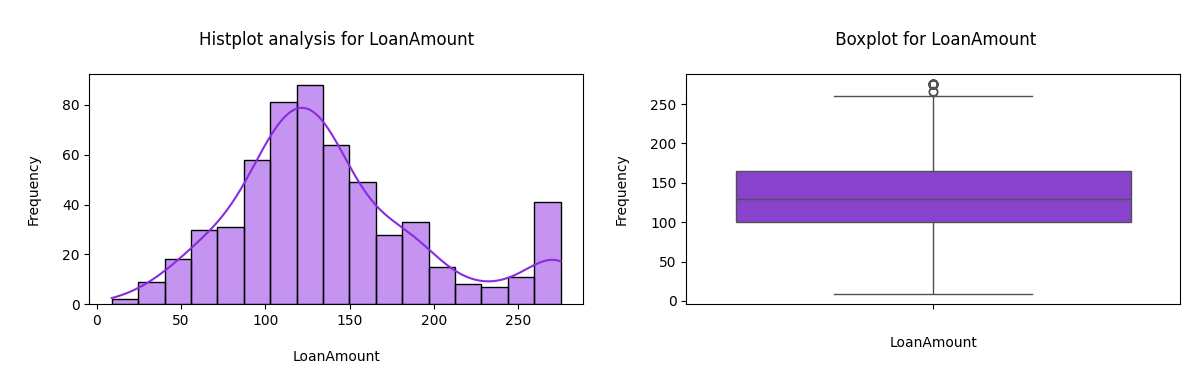

LoanAmount feature skewness: 0.760
LoanAmount feature kurtosis: 0.276
LoanAmount values set are Moderately skewed
--------------------------------------------------------------------------------

 Analysis for Loan_Amount_Term


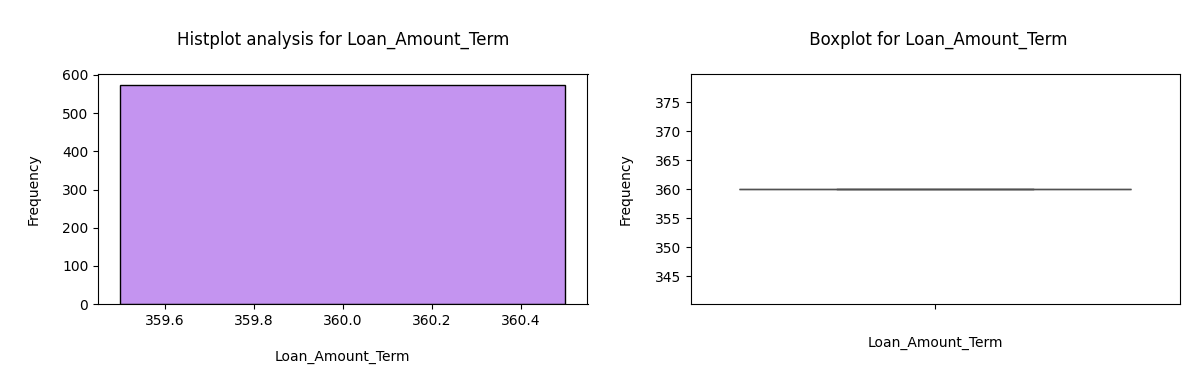

Loan_Amount_Term feature skewness: 0.000
Loan_Amount_Term feature kurtosis: 0.000
Loan_Amount_Term values set are Slightly skewed

--------------------------------------------------------------------------------

 Analysis for Credit_History


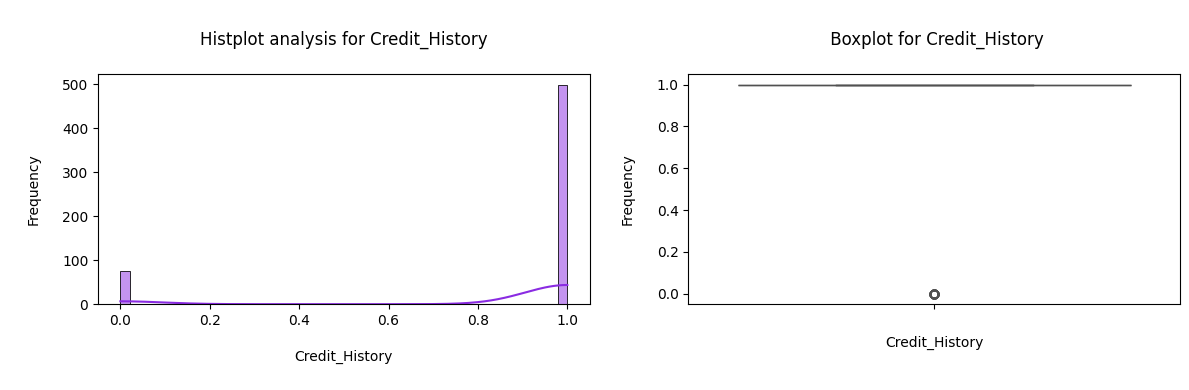

Credit_History feature skewness: -2.194
Credit_History feature kurtosis: 2.826
Credit_History values set are Slightly skewed



In [723]:
for feature in num_features:
    num_univariate_analysis(num_features, feature)

#### categorical

In [724]:
def cat_univariate_analysis(df, feature):
    

    print("--"*40)
    print(f"\n Analysis for {feature}")
    print("=="*40)
    
    

    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    sns.countplot(x=feature, data=df, color="blueviolet")
    plt.title(f"\nCountplot for {feature}\n")
    plt.xlabel(f"\n{feature}\n")
    plt.ylabel(f"\nFrequency\n")


    counts = df[feature].value_counts()
    plt.subplot(1,2,2)
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f"\nPie chart for {feature}\n")
    plt.xlabel(f"\n{feature}\n")

    plt.tight_layout()
    plt.show()






--------------------------------------------------------------------------------

 Analysis for Gender


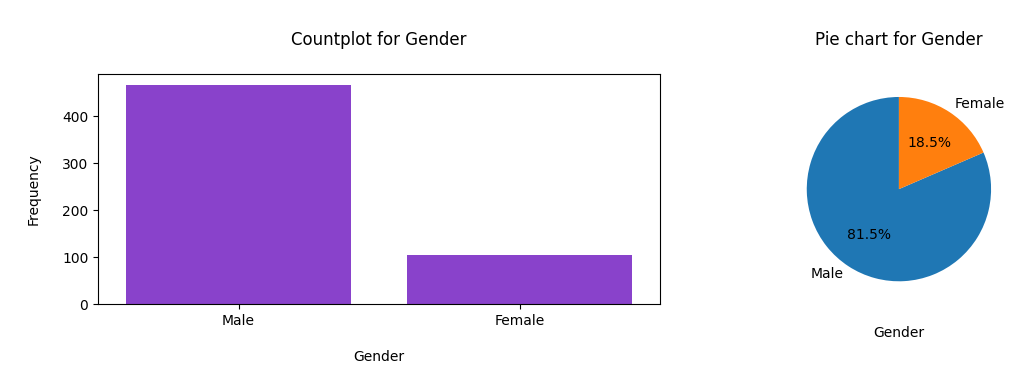

--------------------------------------------------------------------------------

 Analysis for Married


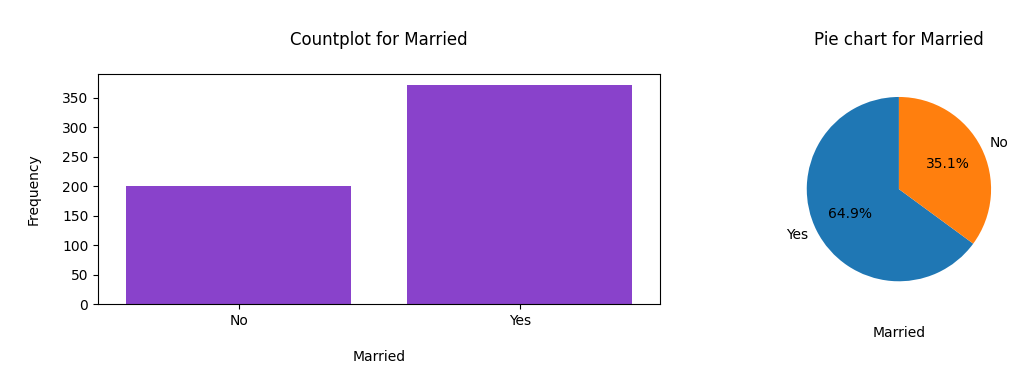

--------------------------------------------------------------------------------

 Analysis for Education


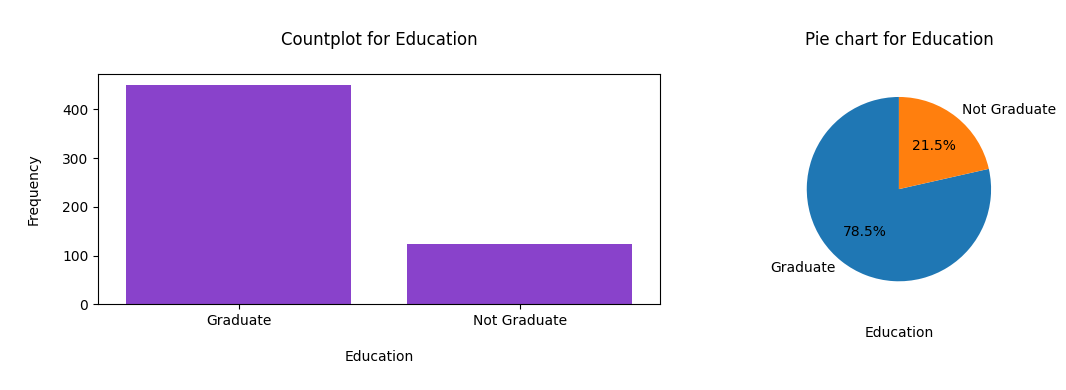

--------------------------------------------------------------------------------

 Analysis for Self_Employed


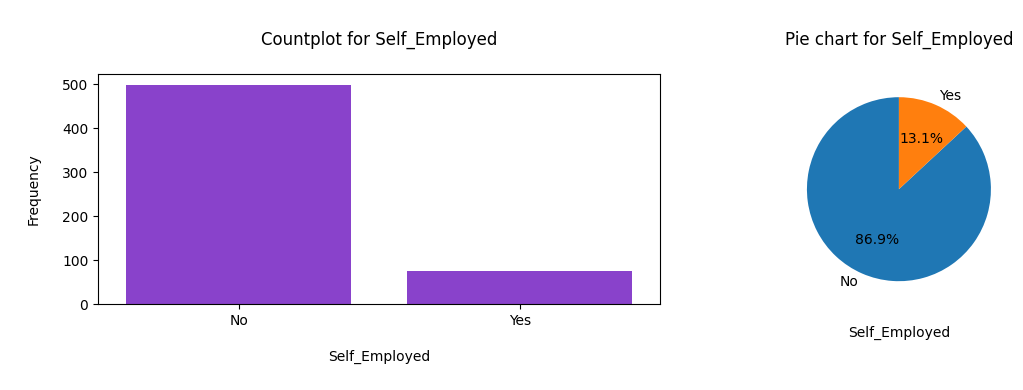

--------------------------------------------------------------------------------

 Analysis for Property_Area


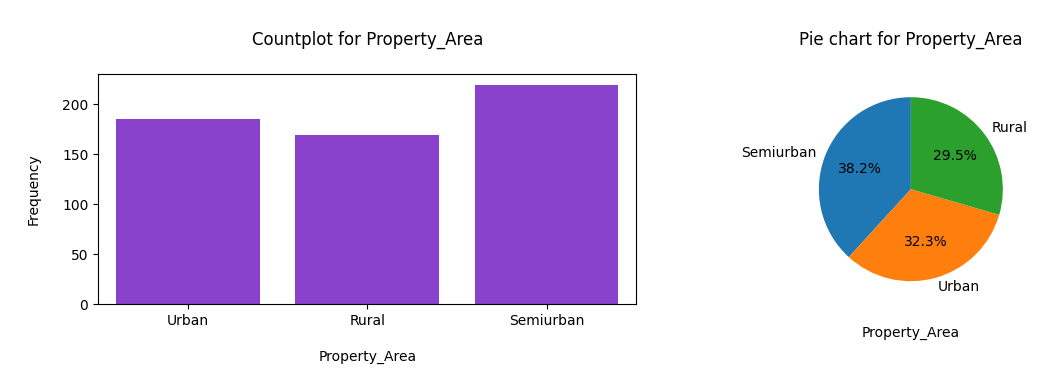

--------------------------------------------------------------------------------

 Analysis for Loan_Status


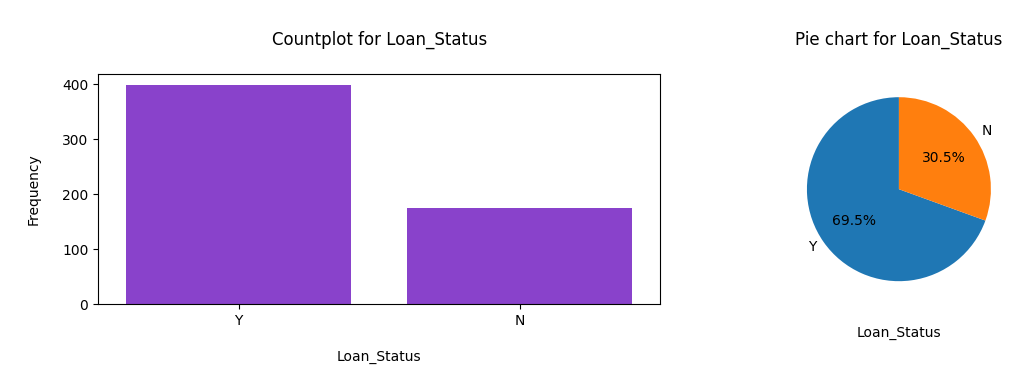

--------------------------------------------------------------------------------

 Analysis for income_rating


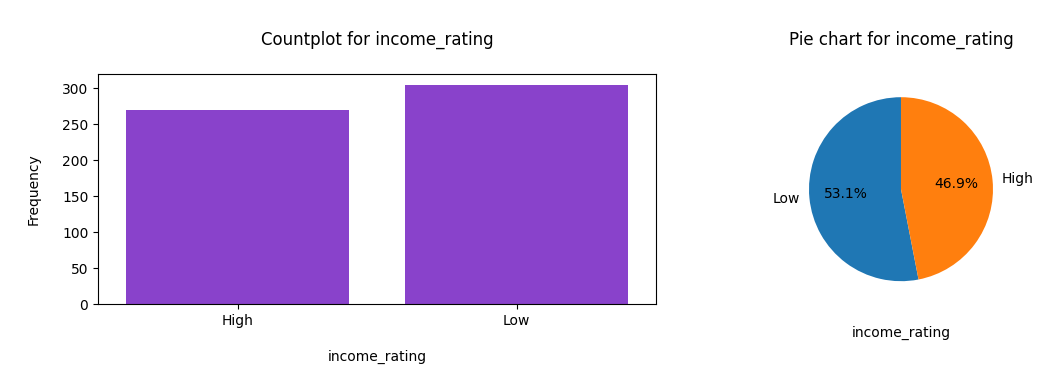

In [725]:
for feature in cat_features:
    cat_univariate_analysis(cat_features, feature)

## Bivariate Analysis

In [726]:
df.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating
0,LP001002,Male,No,0,Graduate,No,8.648397,0.693147,138.629295,360.0,1.0,Urban,Y,High
1,LP001003,Male,Yes,1,Graduate,No,8.397283,7.319865,128.000000,360.0,1.0,Rural,N,High


In [727]:
def bivariate_analysis_pipeline_categorical(df, feature, hue):
    plt.figure(figsize=(8,4))
    sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")
    plt.title(label=f"\nCount plot showing relationship between {feature} and Loan Status\n ")
    plt.xlabel(f"\n{feature}")
    plt.ylabel("Frequency")
    plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


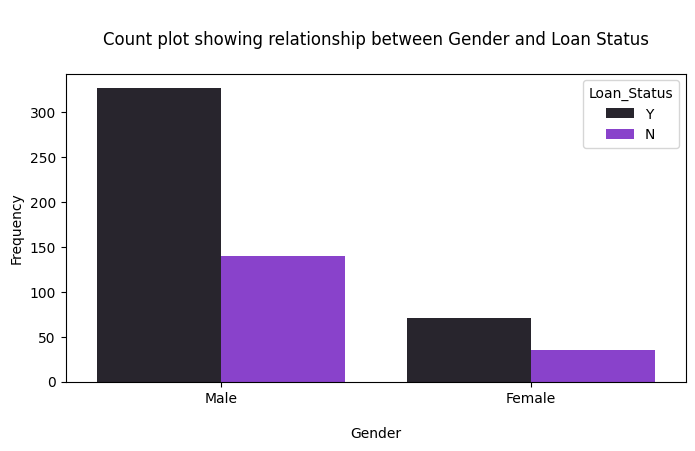

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


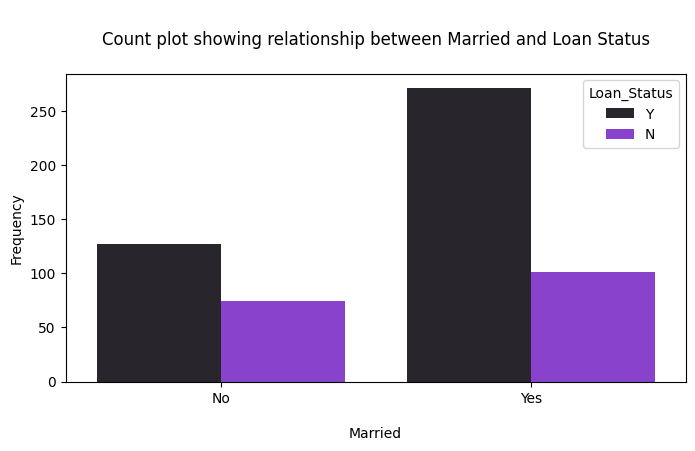

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


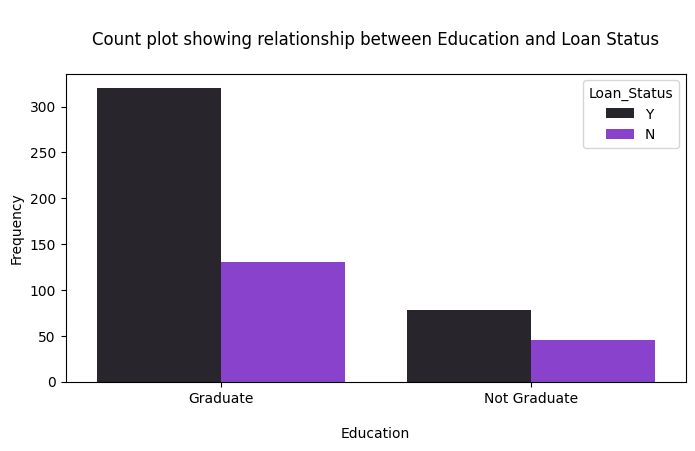

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


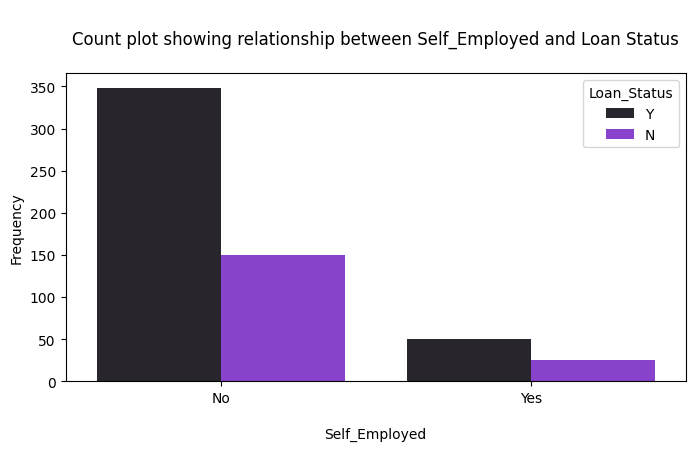

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


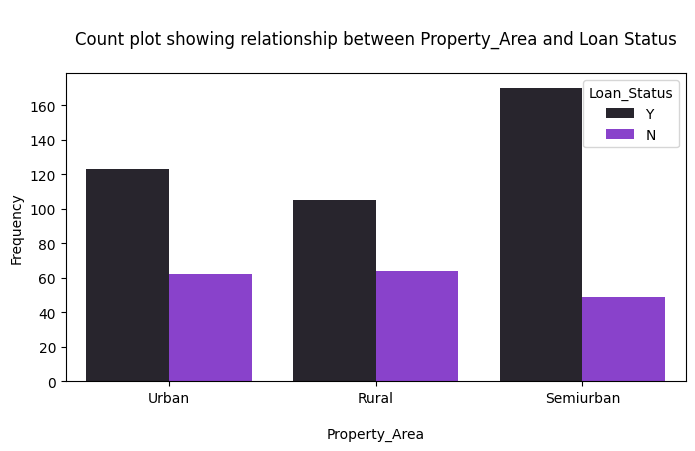

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\235663319.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:blueviolet'` for the same effect.

  sns.countplot(x=feature, hue=hue, data=df, color="blueviolet")


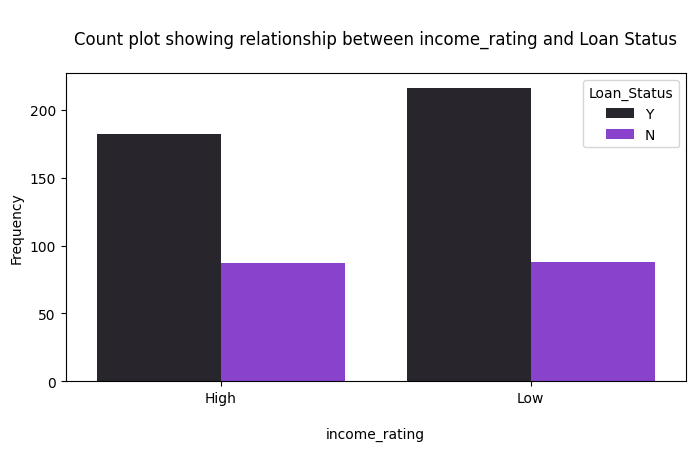

In [728]:




for feature in cat_features.drop(columns=["Loan_Status"]):
    hue = df["Loan_Status"]
    bivariate_analysis_pipeline_categorical(cat_features, feature, hue)





### Correlation with target

In [729]:
def numerify(x):
    if x == 'Y':
        return 1
    else: 
        return 0
    
df["loan_status_label"] = df["Loan_Status"].apply(numerify)
df.head(2)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,income_rating,loan_status_label
0,LP001002,Male,No,0,Graduate,No,8.648397,0.693147,138.629295,360.0,1.0,Urban,Y,High,1
1,LP001003,Male,Yes,1,Graduate,No,8.397283,7.319865,128.000000,360.0,1.0,Rural,N,High,0


In [730]:
def correlation_with_target(df, target_col, figsize=(10,2)):
    """
    Plots a heatmap showing correlation of each numeric feature against target_col.
    Returns a Series of correlations (sorted by absolute magnitude).
    """
    # Keep only numeric columns
    numeric_df = df.select_dtypes(include='number').copy()
    if target_col not in numeric_df.columns:
        raise ValueError(f"Target column '{target_col}' must be numeric and present in the dataframe.")
    # compute correlations of every numeric column with the target
    corrs = numeric_df.corrwith(numeric_df[target_col]).drop(target_col)
    corrs_df = corrs.to_frame(name='corr').T  # shape (1, n)
    plt.figure(figsize=figsize)
    sns.heatmap(
        corrs_df,
        annot=True,
        fmt=".3f",
        cmap="coolwarm",
        center=0,
        vmin=-1,
        vmax=1,
        cbar_kws={'orientation': 'vertical', 'shrink':0.7}
    )
    plt.xticks(rotation=45, ha='right')
    plt.yticks([0], [target_col], rotation=0)
    plt.title(f'Correlation of numeric features with {target_col}', fontsize=12)
    plt.tight_layout()
    plt.show()
    # return sorted correlations for downstream use
    return corrs.reindex(corrs.abs().sort_values(ascending=False).index)







c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


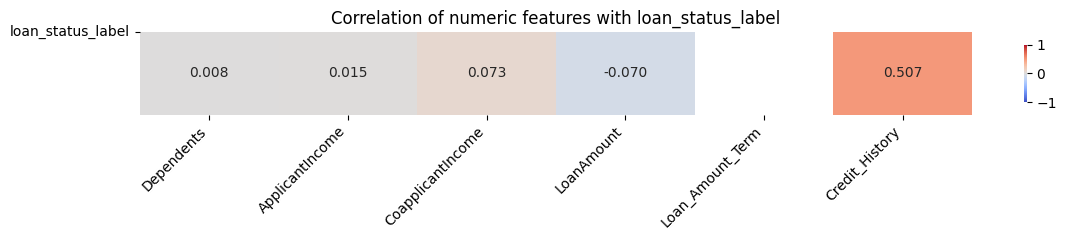

Credit_History       0.506605
CoapplicantIncome    0.073160
LoanAmount          -0.070344
ApplicantIncome      0.014872
Dependents           0.007797
Loan_Amount_Term          NaN
dtype: float64


In [731]:
corr_series = correlation_with_target(df, "loan_status_label", figsize=(12, 2.5))
print(corr_series)

### Numeric Bivariate

In [732]:
from scipy.stats import pearsonr

def numeric_bivariate_plot(df, x_col, y_col):
    """
    Plots the relationship between two numeric variables with a regression line
    and displays the correlation coefficient.

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset containing the numeric columns
    x_col : str
        Name of the first numeric variable (x-axis)
    y_col : str
        Name of the second numeric variable (y-axis)
    """

    # Calculate correlation coefficient
    corr, p_value = pearsonr(df[x_col], df[y_col])

    # Create plot
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df, x=x_col, y=y_col, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    
    # Title and labels
    plt.title(f"{y_col} vs {x_col}\nCorrelation: {corr:.3f} (p={p_value:.3f})", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    plt.show()


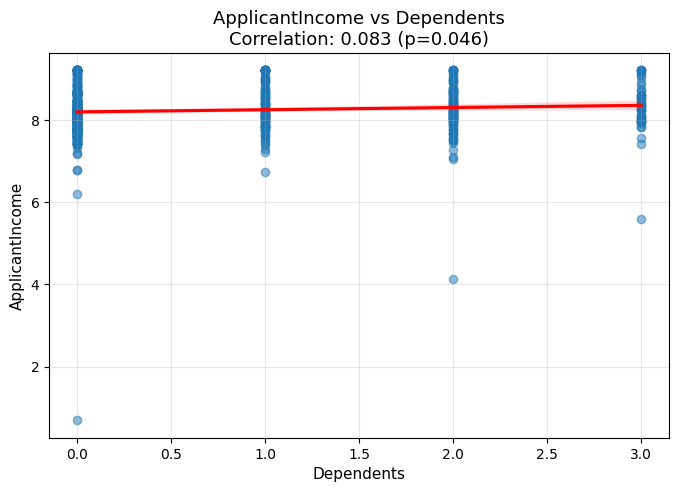

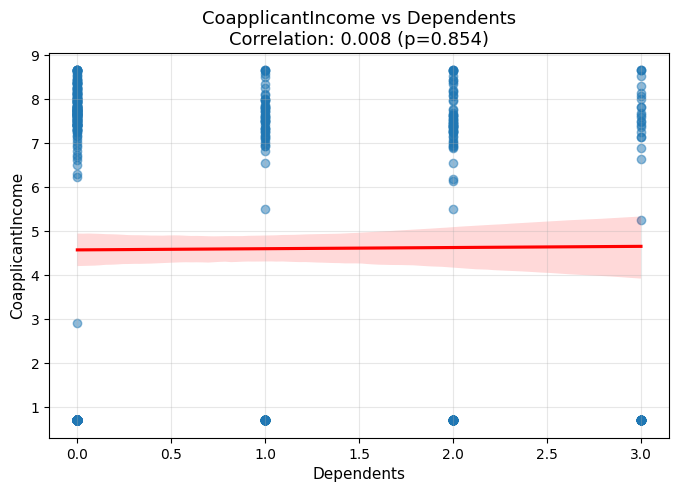

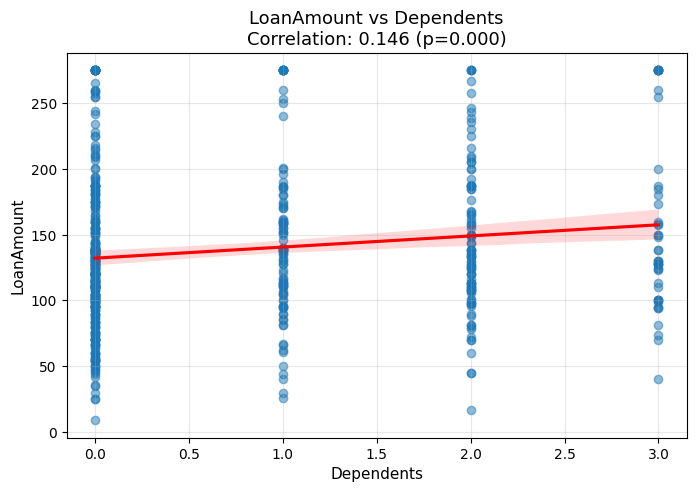

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\640384412.py:19: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_value = pearsonr(df[x_col], df[y_col])


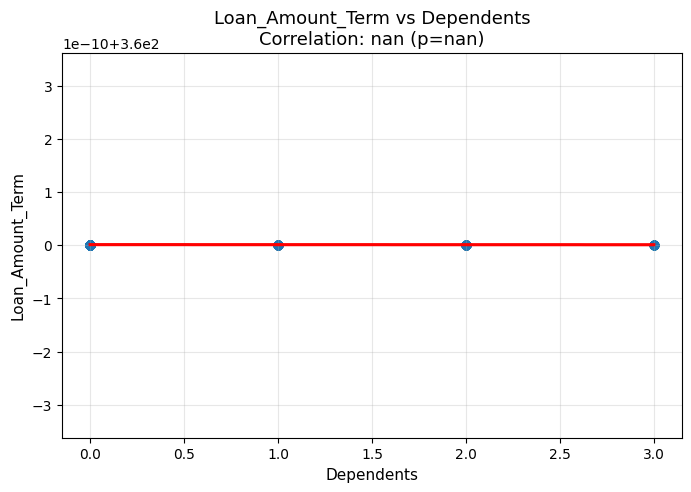

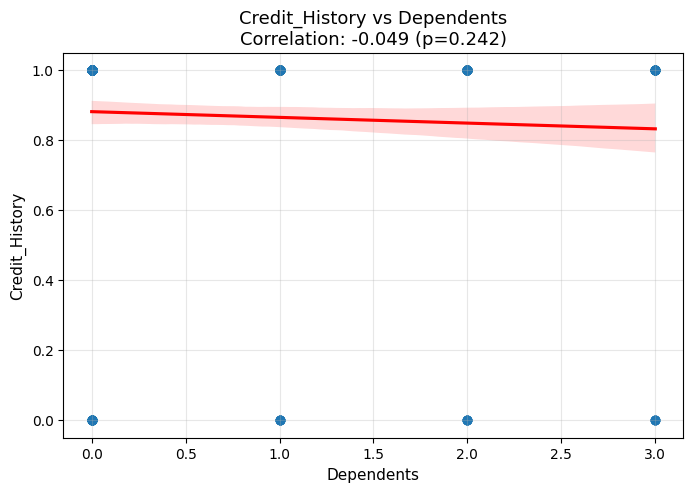

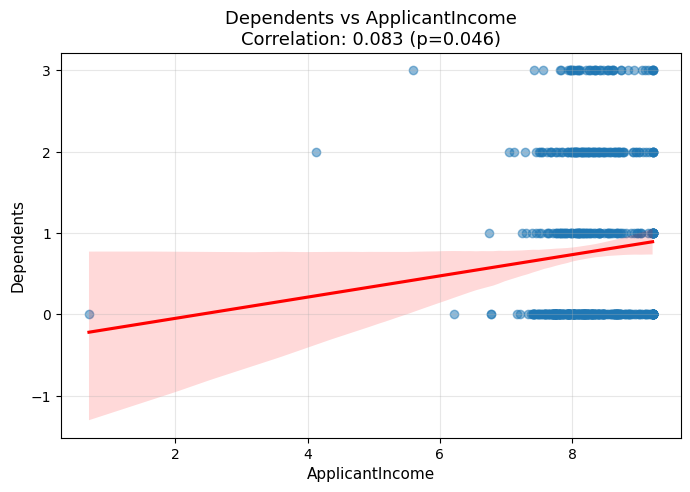

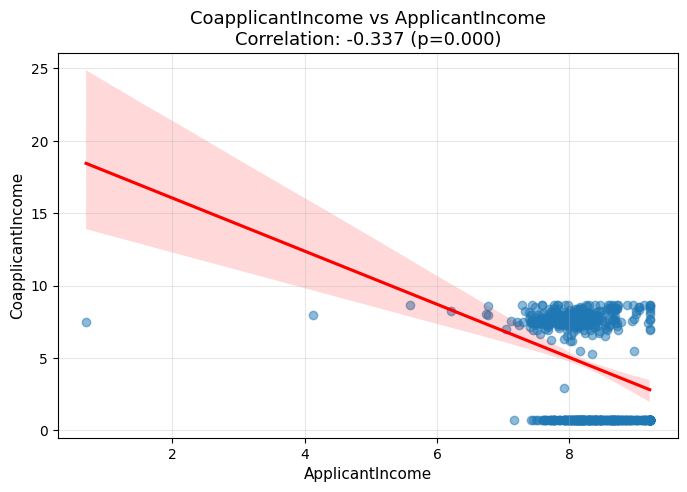

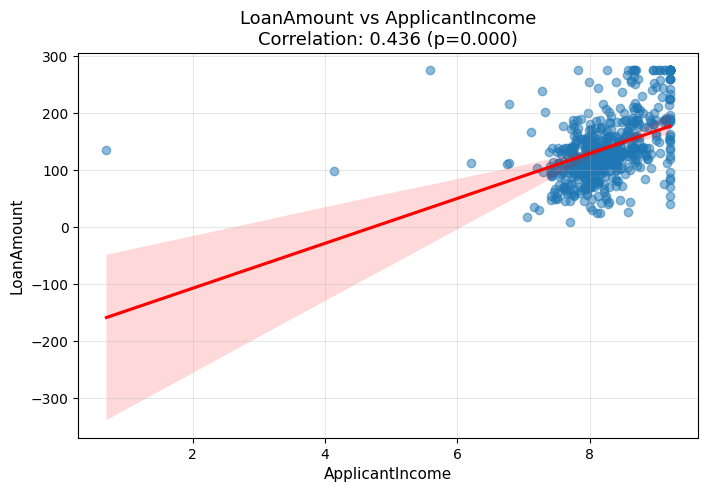

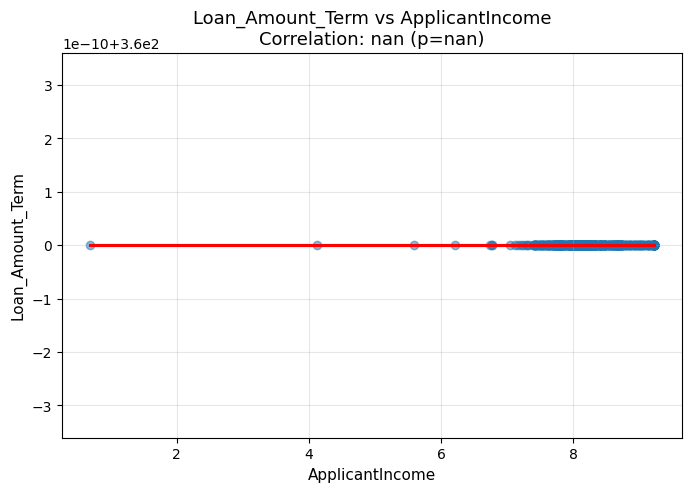

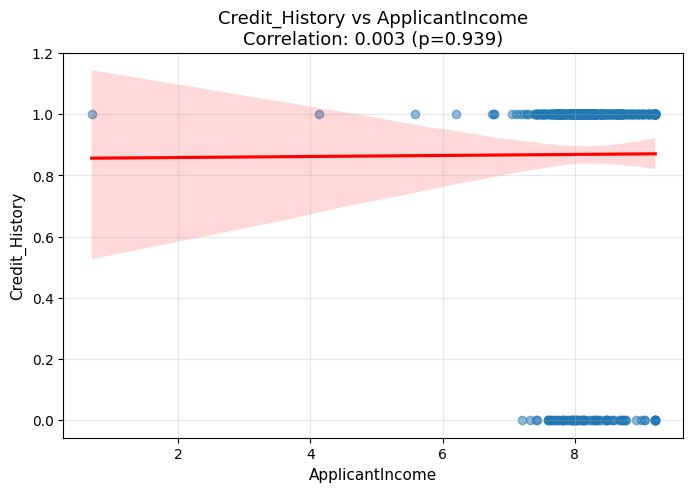

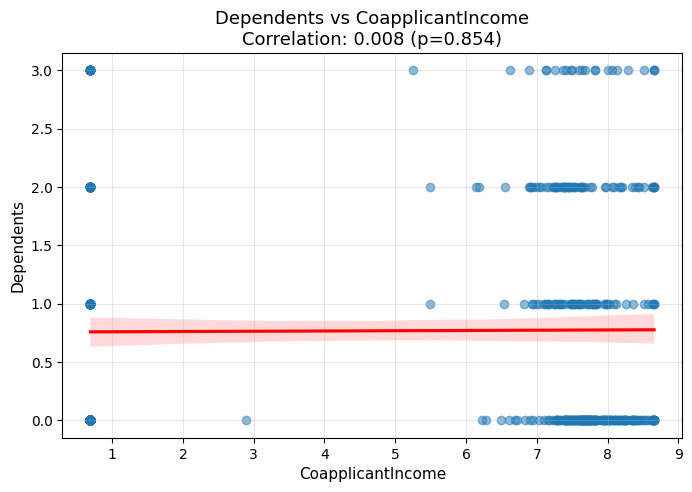

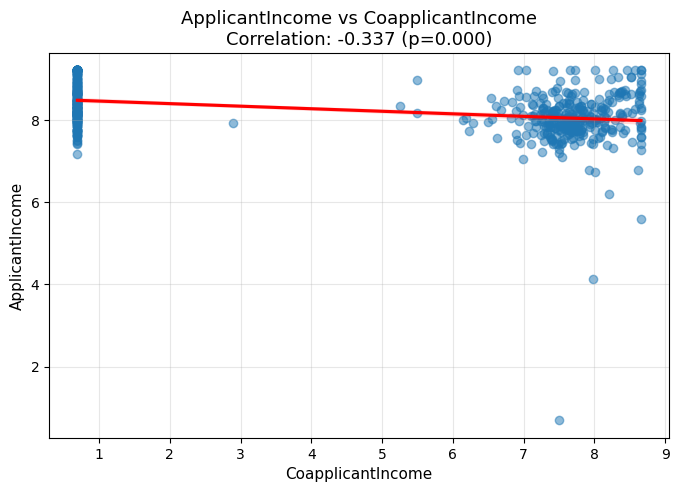

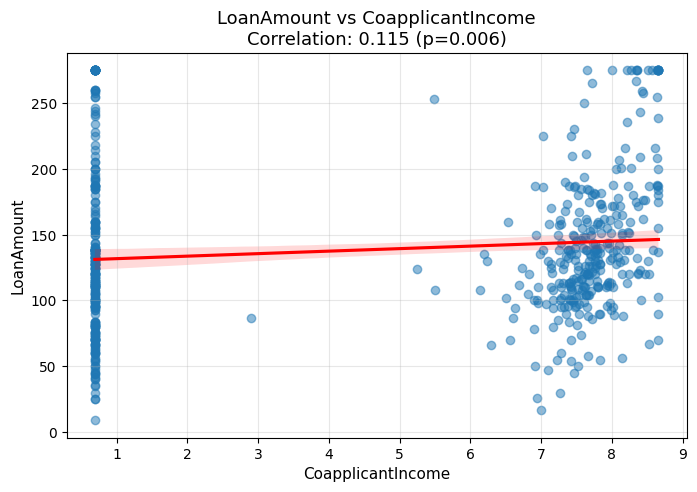

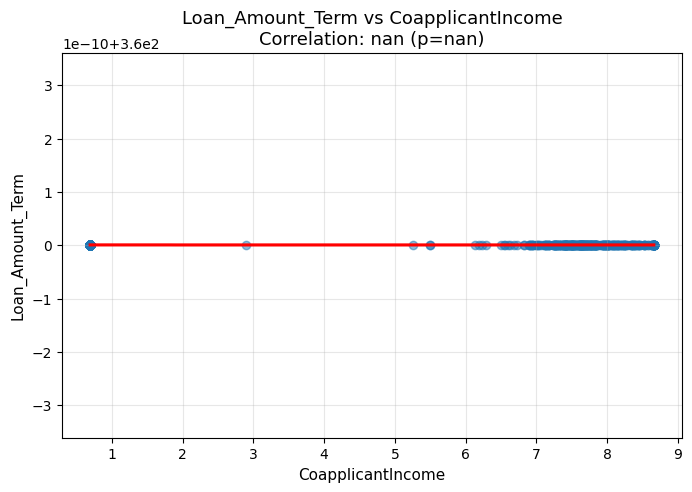

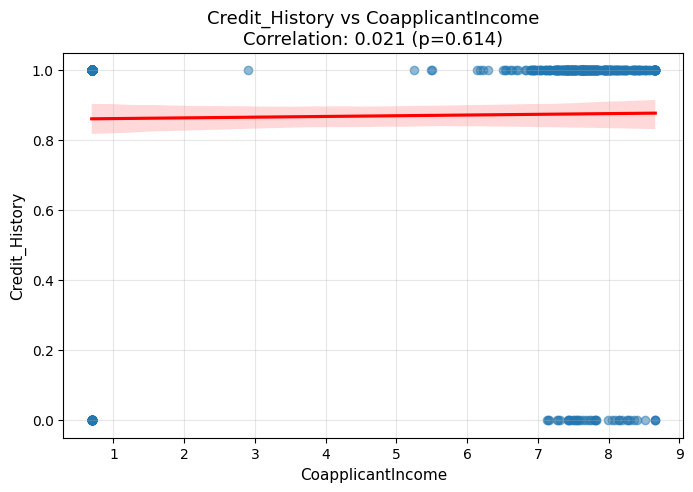

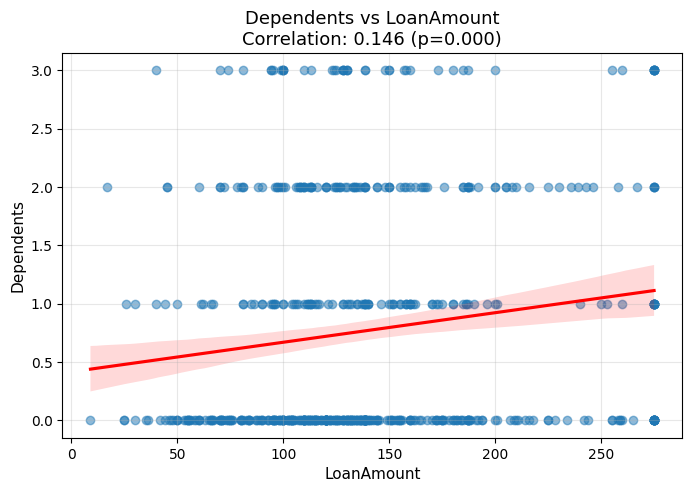

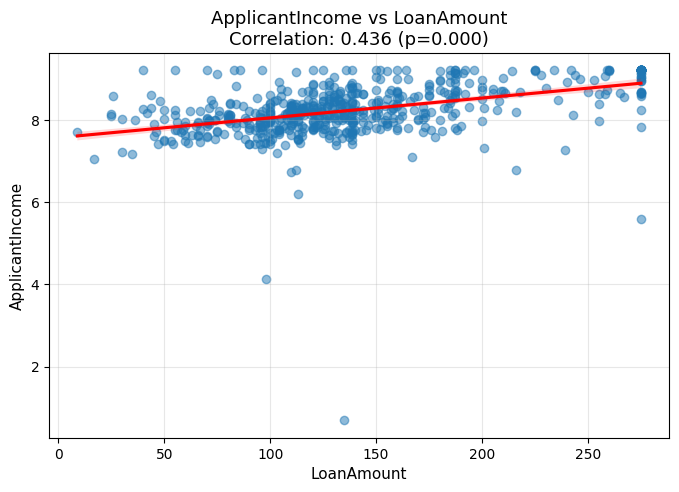

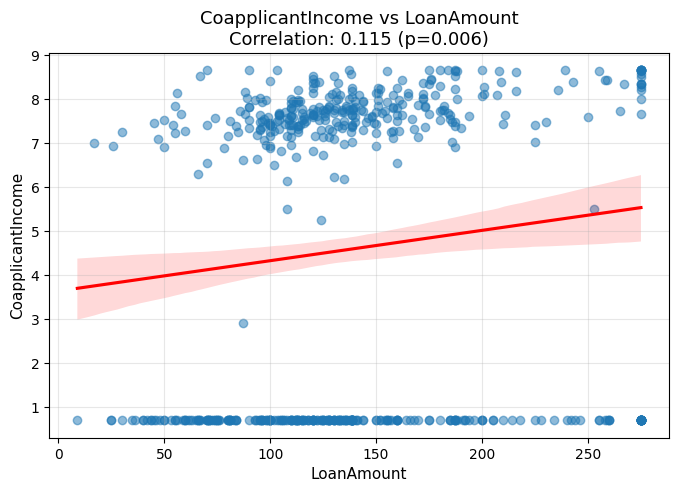

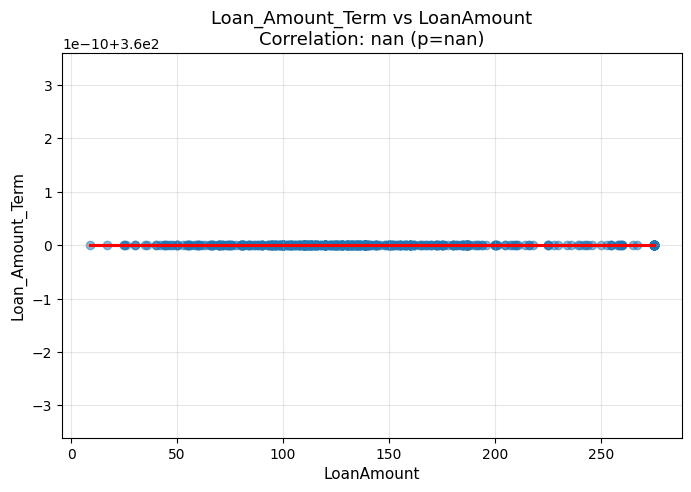

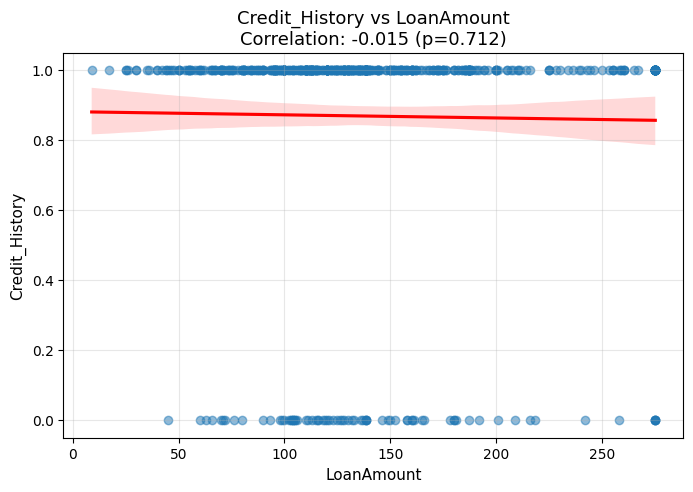

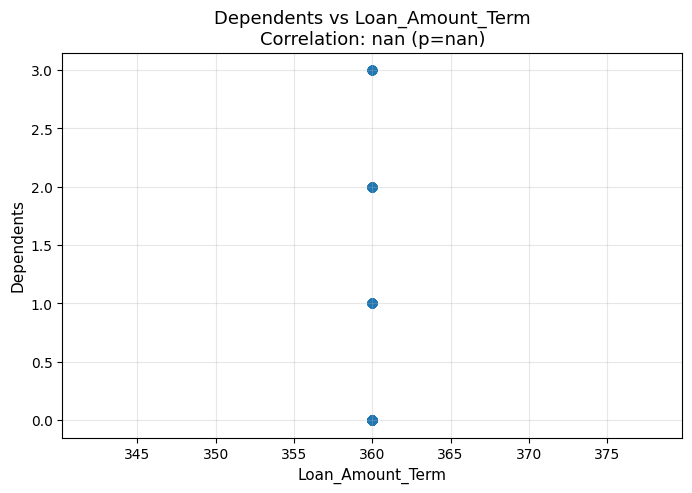

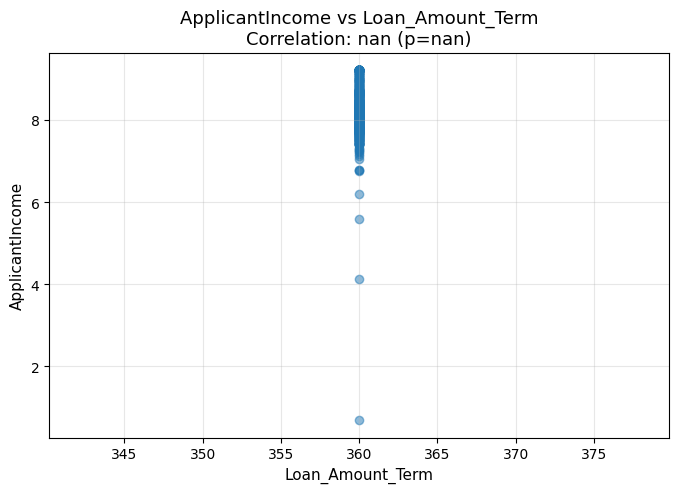

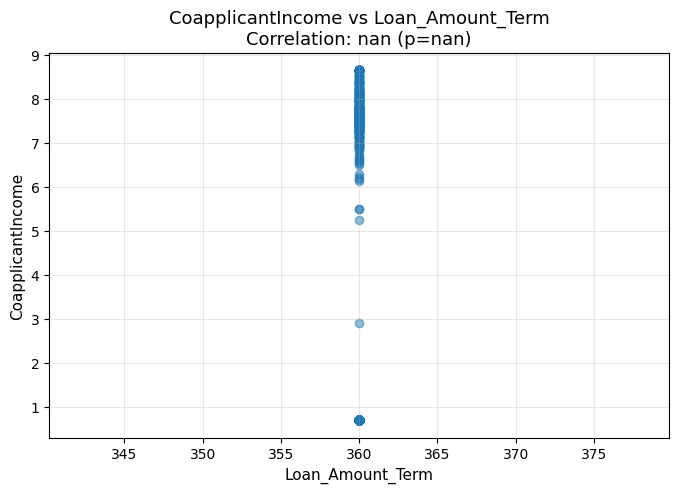

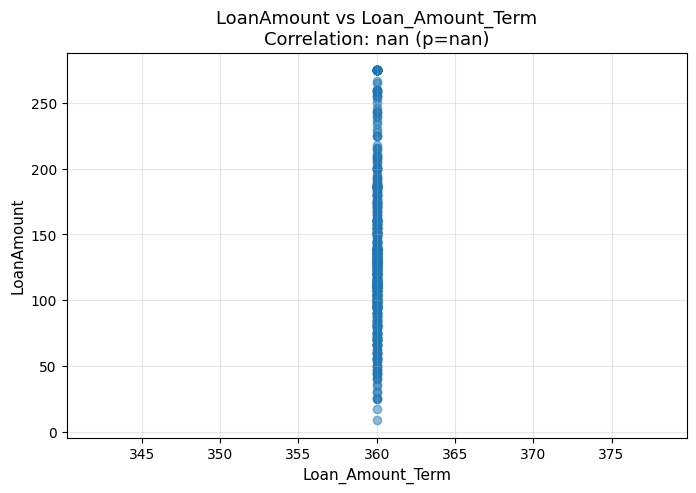

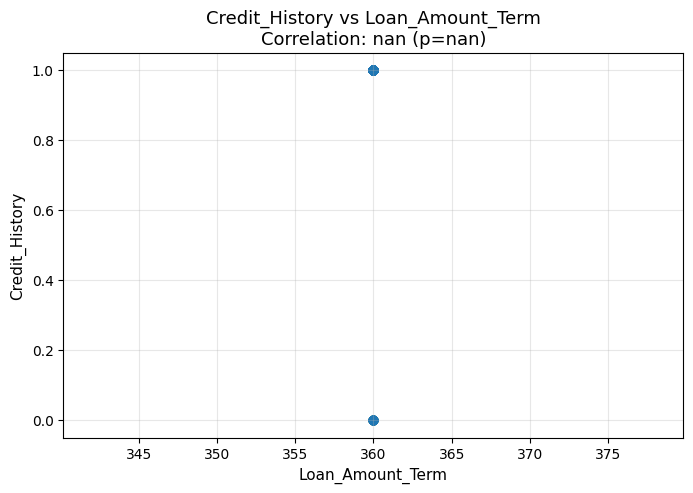

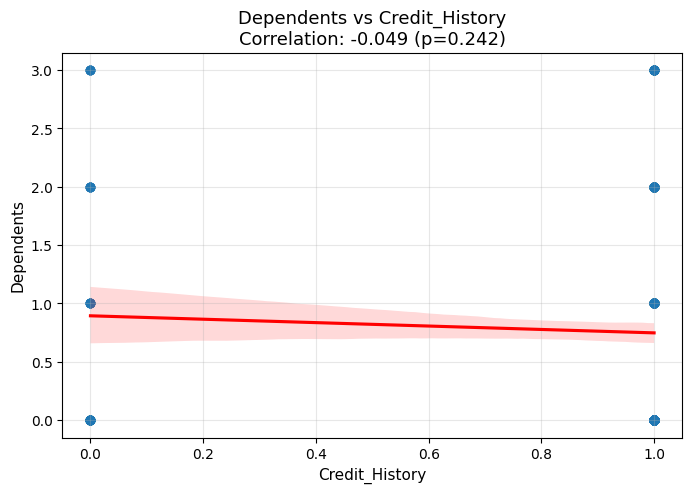

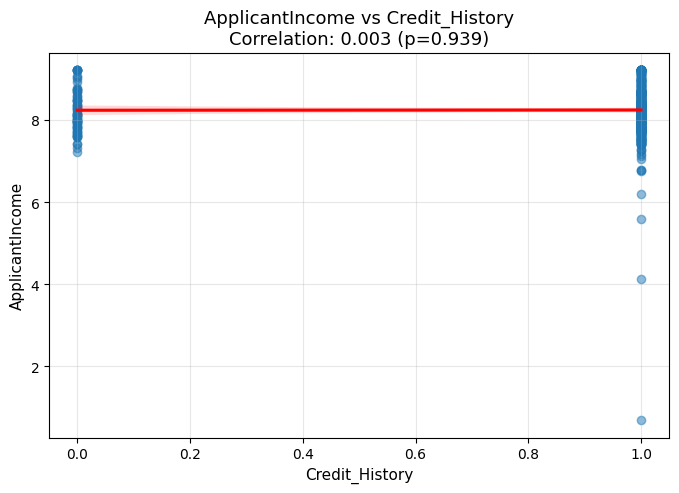

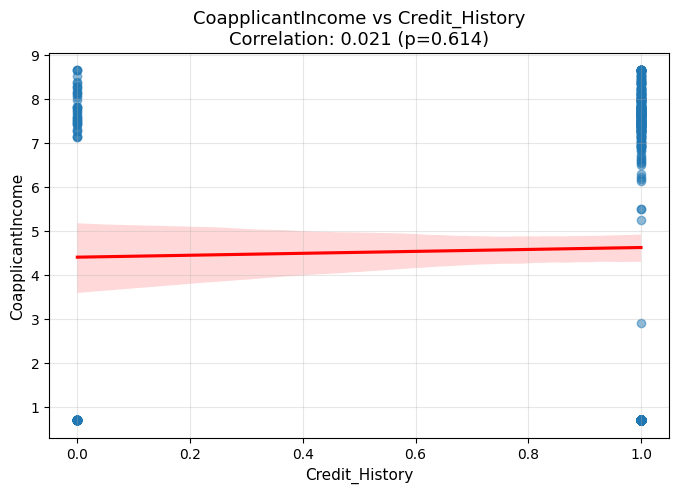

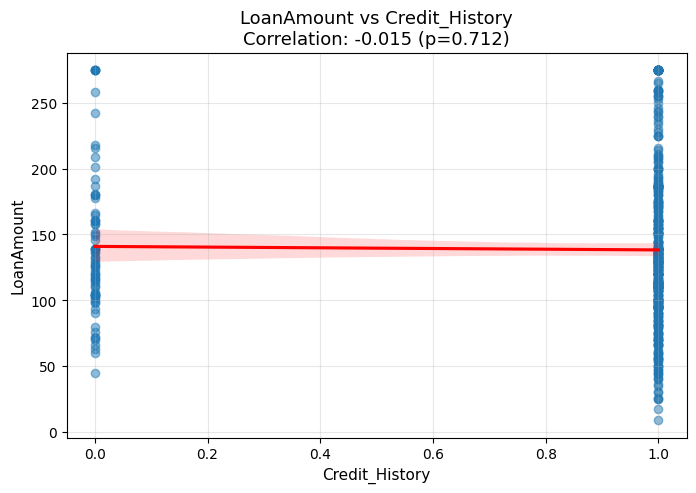

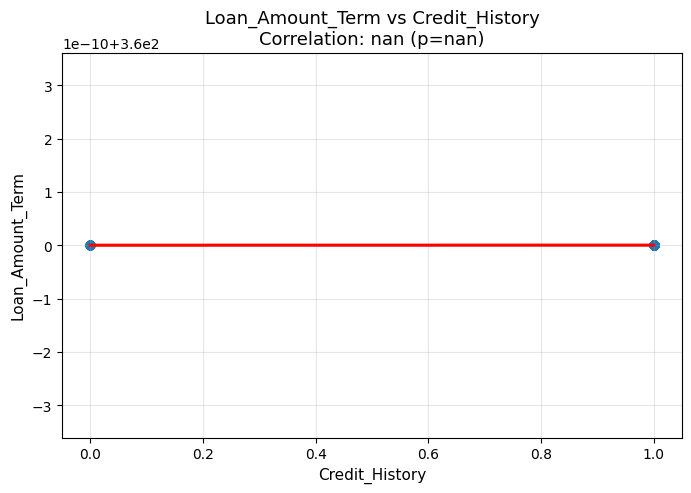

In [733]:
for feature in num_features:
    for feature2 in num_features:
        if feature != feature2:
            numeric_bivariate_plot(num_features, feature, feature2)

### Categorical Bivariate

In [734]:
def bivariate_num_cat(df, feature, target='quality_label'):
    """
    Plots and summarizes relationship between a numerical feature and a categorical target.
    """
    print(f" Feature: {feature} vs {target}")
    print("="*50)

    # Group summary
    summary = df.groupby(target)[feature].describe()[['mean','std','min','max']]
    print(summary)
    print()

    plt.figure(figsize=(10,5))

    # Boxplot + mean line
    sns.boxplot(x=target, y=feature, data=df, palette='Set2')
    plt.title(f'{feature} across {target} categories', fontsize=13)
    plt.xlabel(target)
    plt.ylabel(feature)
    plt.show()

    


 Feature: Dependents vs Gender
            mean       std  min  max
Gender                              
Female  0.396226  0.739102  0.0  3.0
Male    0.850107  1.043586  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


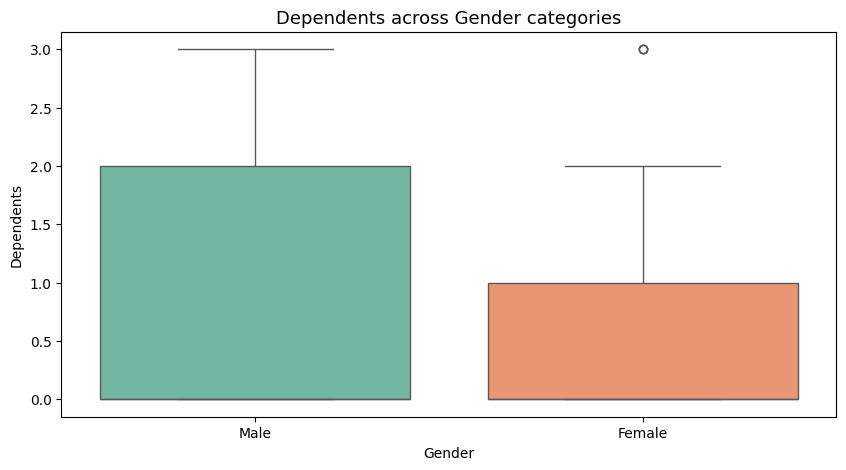

 Feature: Dependents vs Married
             mean       std  min  max
Married                              
No       0.283582  0.681307  0.0  3.0
Yes      1.026882  1.061113  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


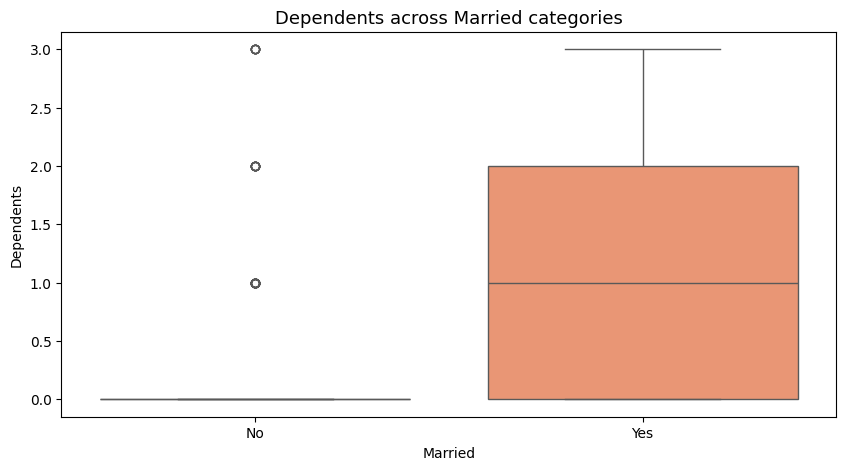

 Feature: Dependents vs Education
                  mean       std  min  max
Education                                 
Graduate      0.733333  0.987675  0.0  3.0
Not Graduate  0.886179  1.080401  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


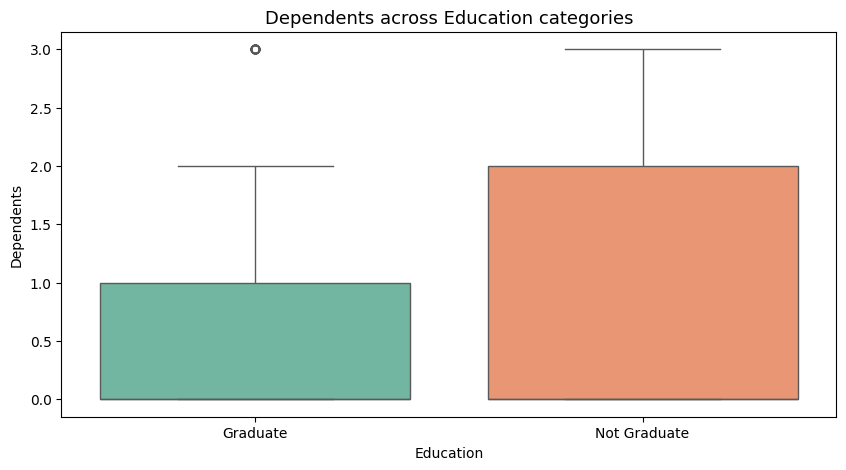

 Feature: Dependents vs Self_Employed
                   mean       std  min  max
Self_Employed                              
No             0.742972  1.010110  0.0  3.0
Yes            0.920000  0.996751  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


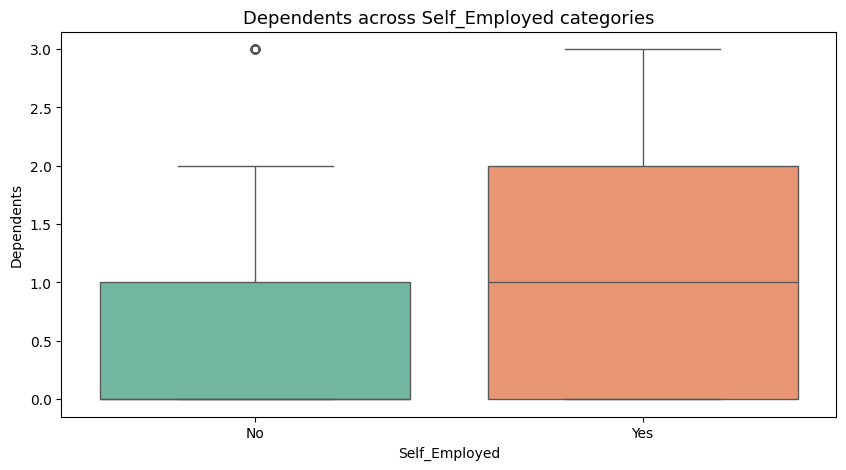

 Feature: Dependents vs Property_Area
                   mean       std  min  max
Property_Area                              
Rural          0.757396  1.060810  0.0  3.0
Semiurban      0.757991  1.004973  0.0  3.0
Urban          0.783784  0.970632  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


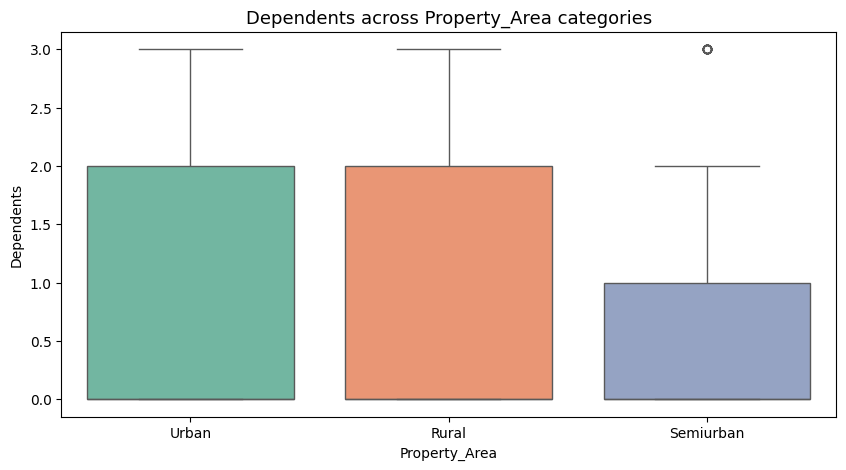

 Feature: Dependents vs income_rating
                   mean       std  min  max
income_rating                              
High           0.899628  1.062049  0.0  3.0
Low            0.648026  0.946313  0.0  3.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


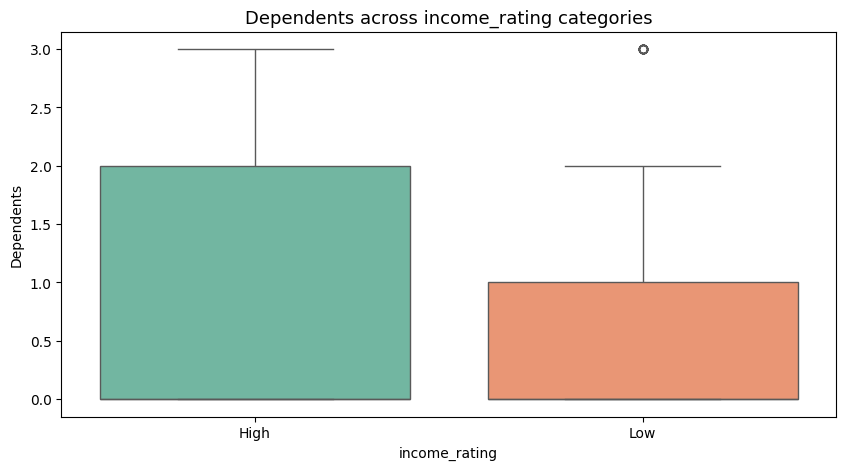

 Feature: ApplicantIncome vs Gender
            mean       std       min       max
Gender                                        
Female  8.133116  0.708393  4.127134  9.217862
Male    8.268407  0.629081  0.693147  9.217862



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


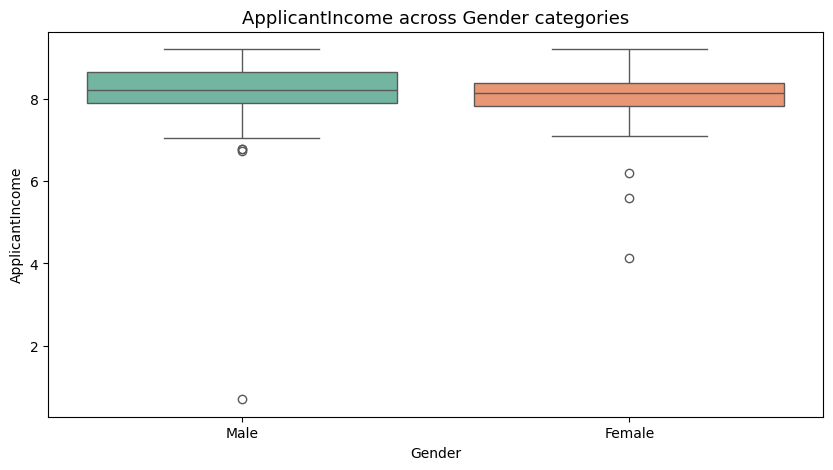

 Feature: ApplicantIncome vs Married
             mean       std       min       max
Married                                        
No       8.252974  0.548261  5.590987  9.217862
Yes      8.238195  0.693718  0.693147  9.217862



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


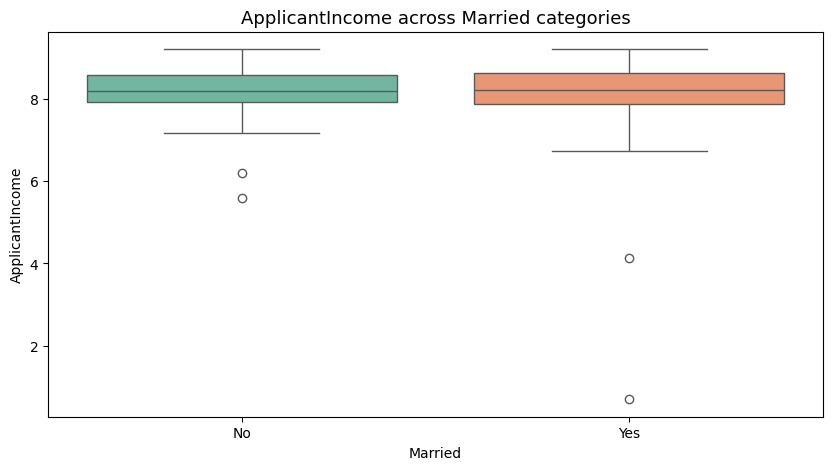

 Feature: ApplicantIncome vs Education
                  mean       std       min       max
Education                                           
Graduate      8.295629  0.660010  0.693147  9.217862
Not Graduate  8.052221  0.553492  4.127134  9.217862



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


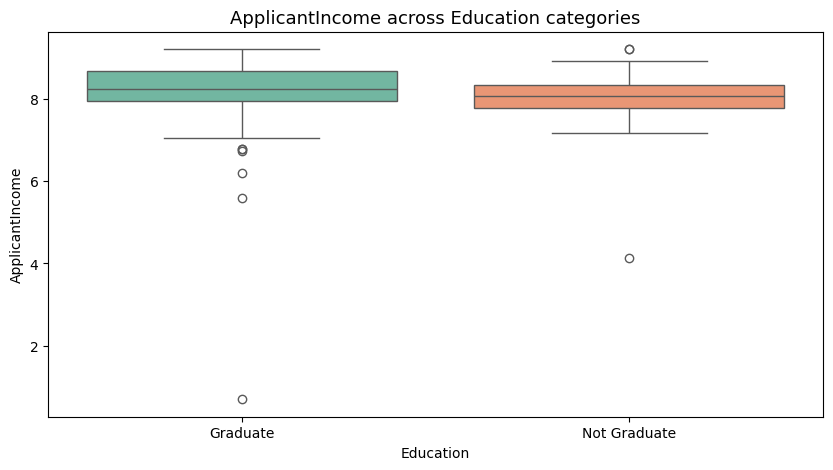

 Feature: ApplicantIncome vs Self_Employed
                   mean       std       min       max
Self_Employed                                        
No             8.195382  0.641489  0.693147  9.217862
Yes            8.562082  0.585914  6.747587  9.217862



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


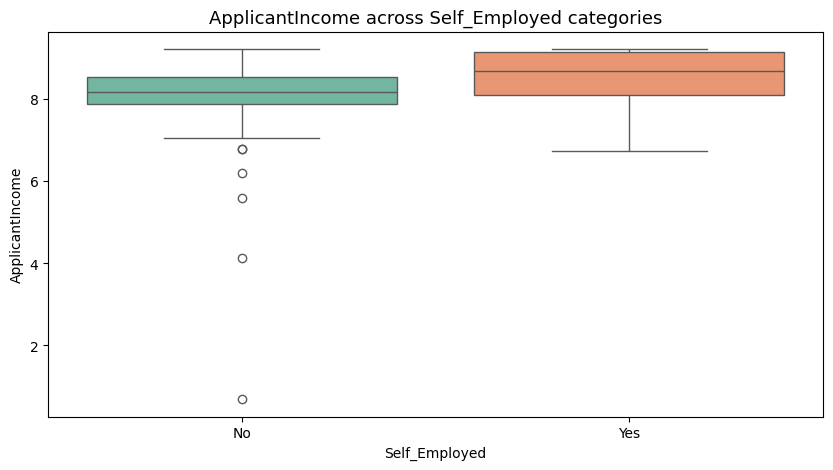

 Feature: ApplicantIncome vs Property_Area
                   mean       std       min       max
Property_Area                                        
Rural          8.266900  0.794344  0.693147  9.217862
Semiurban      8.248189  0.556314  4.127134  9.217862
Urban          8.216198  0.594268  5.590987  9.217862



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


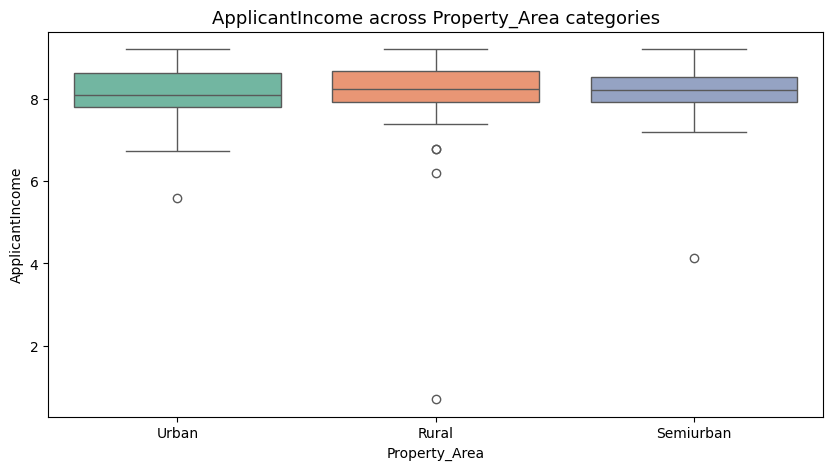

 Feature: ApplicantIncome vs income_rating
                   mean       std       min       max
income_rating                                        
High           8.718103  0.330924  8.249836  9.217862
Low            7.823311  0.560156  0.693147  8.242756



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


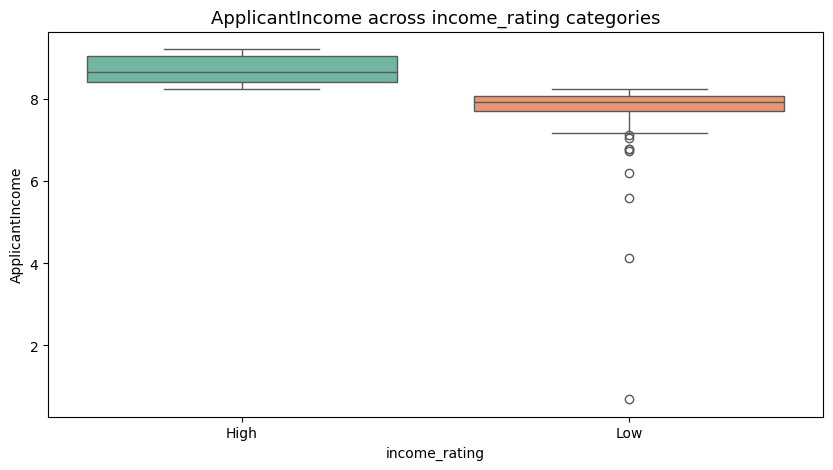

 Feature: CoapplicantIncome vs Gender
            mean       std       min       max
Gender                                        
Female  2.990371  3.300023  0.693147  8.658172
Male    4.953274  3.459201  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


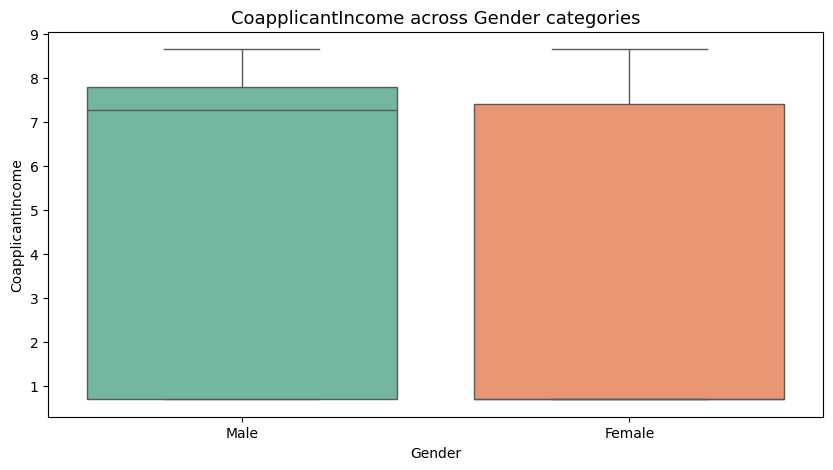

 Feature: CoapplicantIncome vs Married
             mean       std       min       max
Married                                        
No       3.113544  3.403206  0.693147  8.658172
Yes      5.387999  3.308529  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


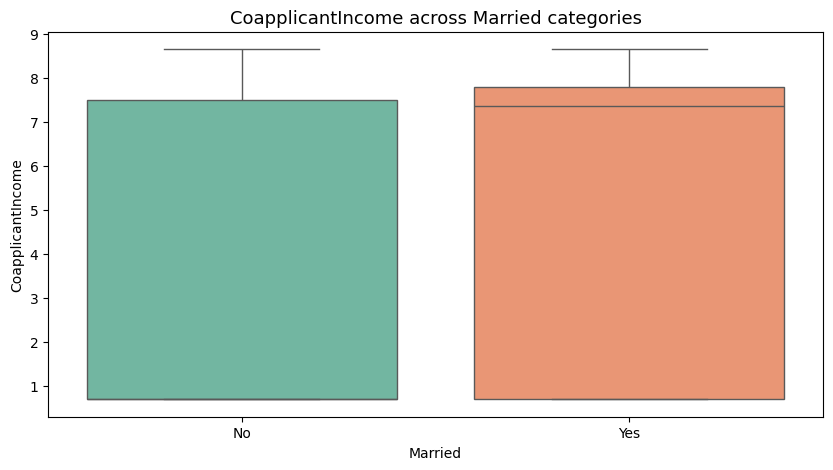

 Feature: CoapplicantIncome vs Education
                  mean       std       min       max
Education                                           
Graduate      4.520825  3.552783  0.693147  8.658172
Not Graduate  4.843796  3.357209  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


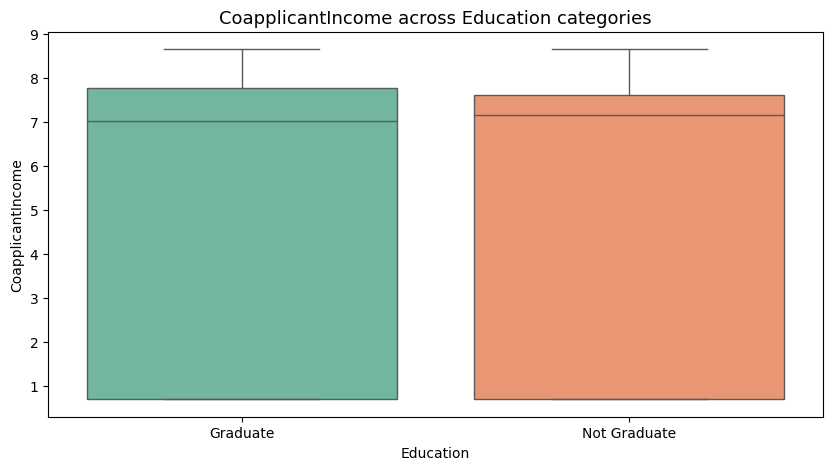

 Feature: CoapplicantIncome vs Self_Employed
                   mean       std       min       max
Self_Employed                                        
No             4.733155  3.486169  0.693147  8.658172
Yes            3.640625  3.553613  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


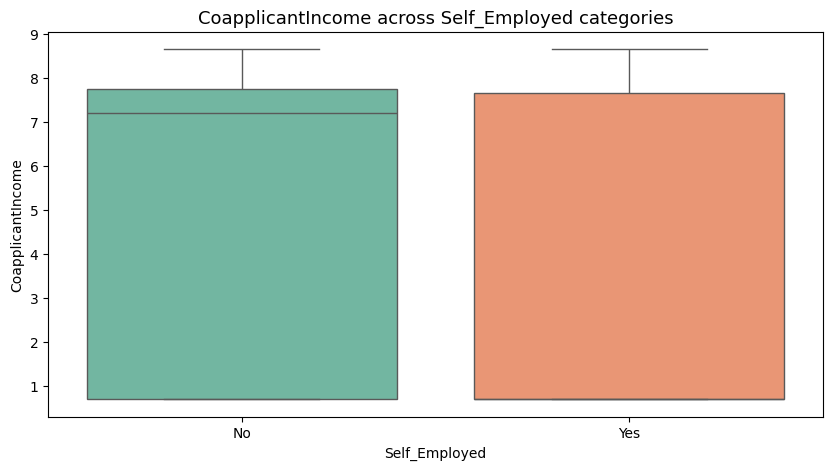

 Feature: CoapplicantIncome vs Property_Area
                   mean       std       min       max
Property_Area                                        
Rural          4.815598  3.516647  0.693147  8.658172
Semiurban      4.519467  3.513117  0.693147  8.658172
Urban          4.467885  3.513863  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


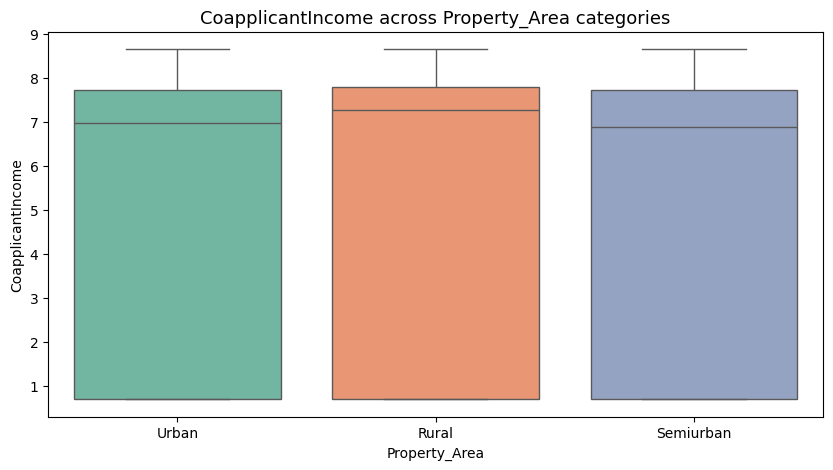

 Feature: CoapplicantIncome vs income_rating
                   mean       std       min       max
income_rating                                        
High           3.471572  3.502963  0.693147  8.658172
Low            5.579952  3.213804  0.693147  8.658172



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


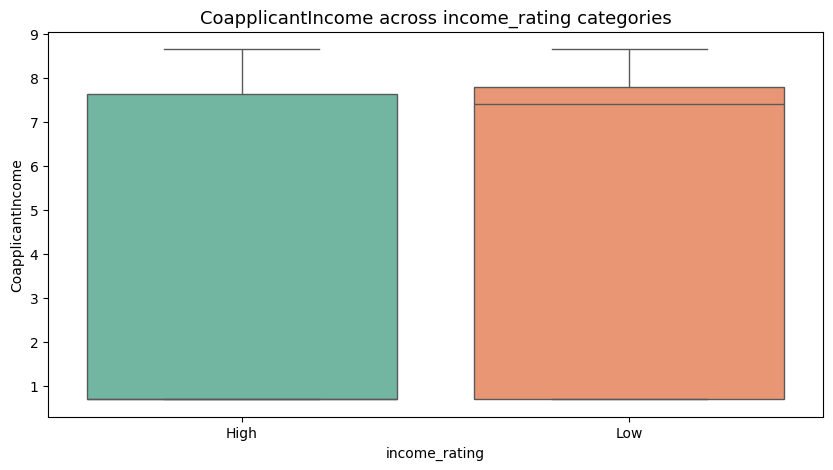

 Feature: LoanAmount vs Gender
              mean        std   min    max
Gender                                    
Female  121.728855  55.490477   9.0  275.0
Male    142.465369  58.324300  17.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


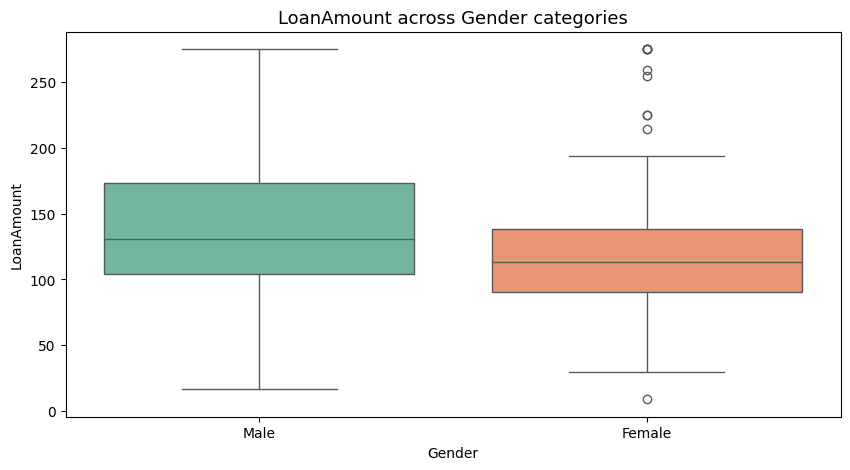

 Feature: LoanAmount vs Married
               mean        std   min    max
Married                                    
No       125.191070  55.377972   9.0  275.0
Yes      145.890271  58.655483  17.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


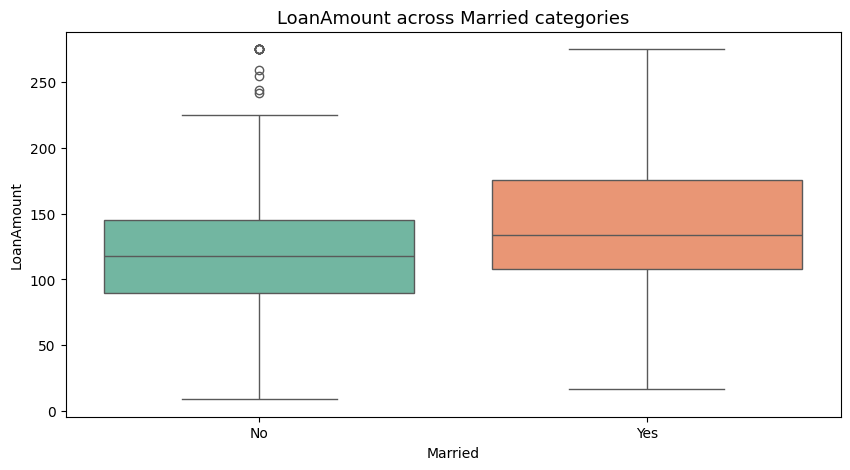

 Feature: LoanAmount vs Education
                    mean        std   min    max
Education                                       
Graduate      143.829291  61.417061   9.0  275.0
Not Graduate  119.604919  40.013231  25.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


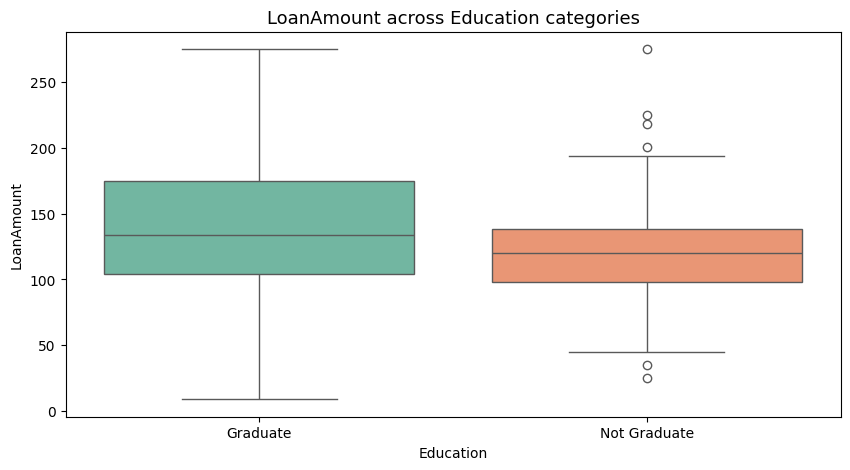

 Feature: LoanAmount vs Self_Employed
                     mean        std   min    max
Self_Employed                                    
No             136.111843  57.314591   9.0  275.0
Yes            155.345172  62.485465  25.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


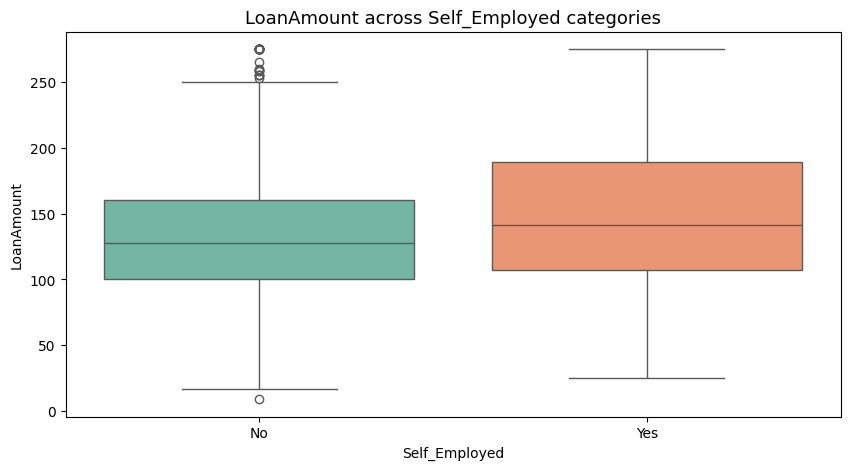

 Feature: LoanAmount vs Property_Area
                     mean        std   min    max
Property_Area                                    
Rural          142.986839  54.747396  40.0  275.0
Semiurban      139.226106  57.419683  25.0  275.0
Urban          133.942124  62.381308   9.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


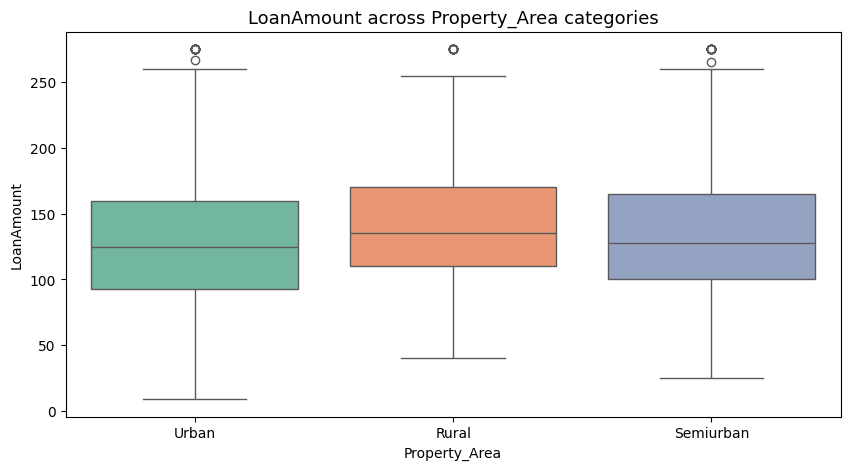

 Feature: LoanAmount vs income_rating
                     mean        std   min    max
income_rating                                    
High           166.969010  62.010014  26.0  275.0
Low            113.552376  40.942958   9.0  275.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


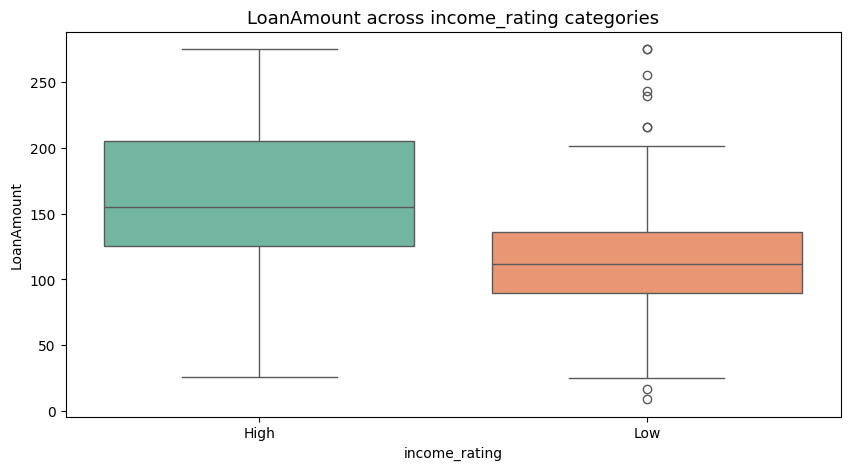

 Feature: Loan_Amount_Term vs Gender
         mean  std    min    max
Gender                          
Female  360.0  0.0  360.0  360.0
Male    360.0  0.0  360.0  360.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


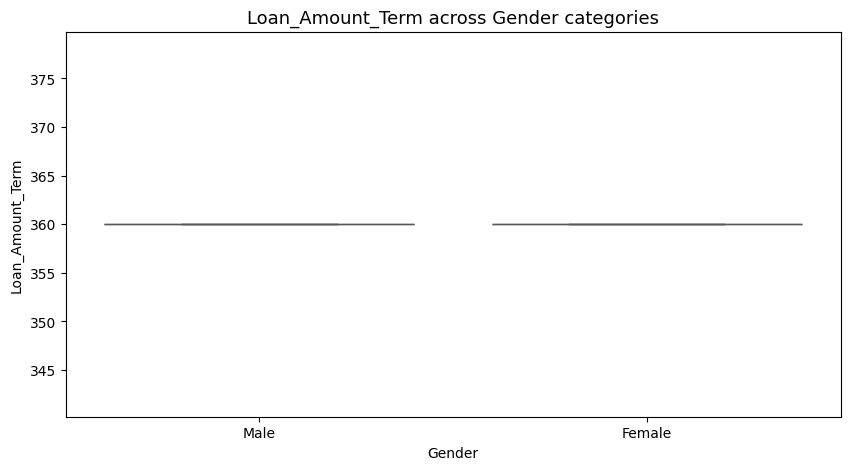

C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


 Feature: Loan_Amount_Term vs Married
          mean  std    min    max
Married                          
No       360.0  0.0  360.0  360.0
Yes      360.0  0.0  360.0  360.0



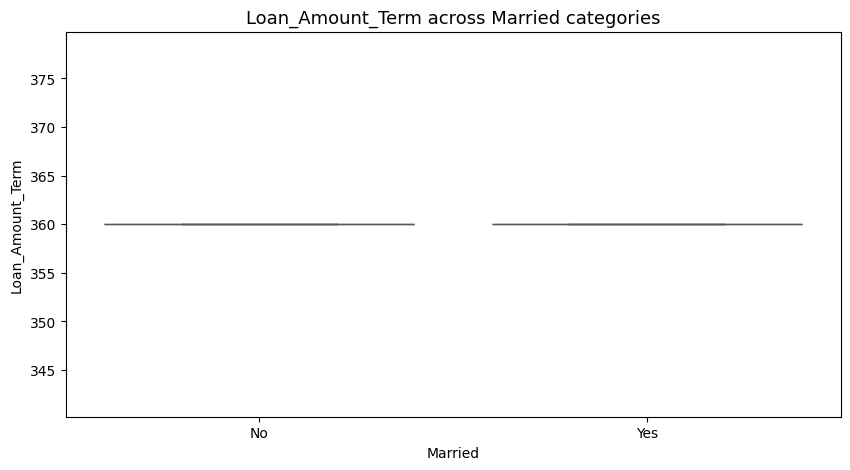

 Feature: Loan_Amount_Term vs Education
               mean  std    min    max
Education                             
Graduate      360.0  0.0  360.0  360.0
Not Graduate  360.0  0.0  360.0  360.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


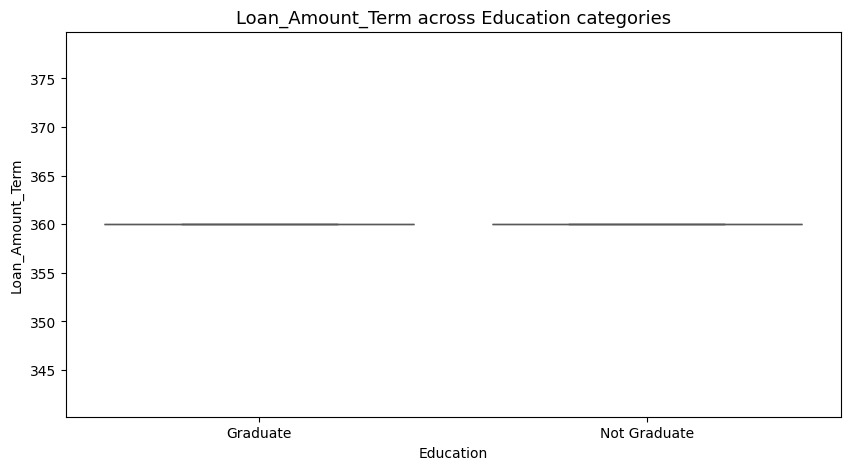

 Feature: Loan_Amount_Term vs Self_Employed
                mean  std    min    max
Self_Employed                          
No             360.0  0.0  360.0  360.0
Yes            360.0  0.0  360.0  360.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


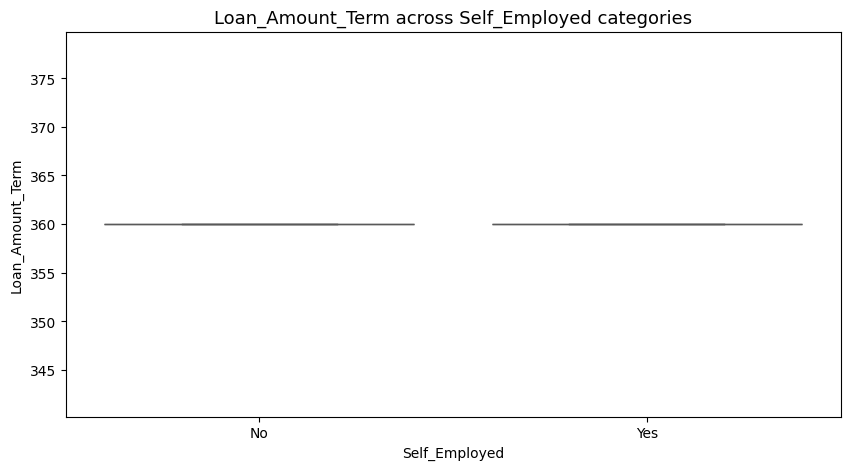

 Feature: Loan_Amount_Term vs Property_Area
                mean  std    min    max
Property_Area                          
Rural          360.0  0.0  360.0  360.0
Semiurban      360.0  0.0  360.0  360.0
Urban          360.0  0.0  360.0  360.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


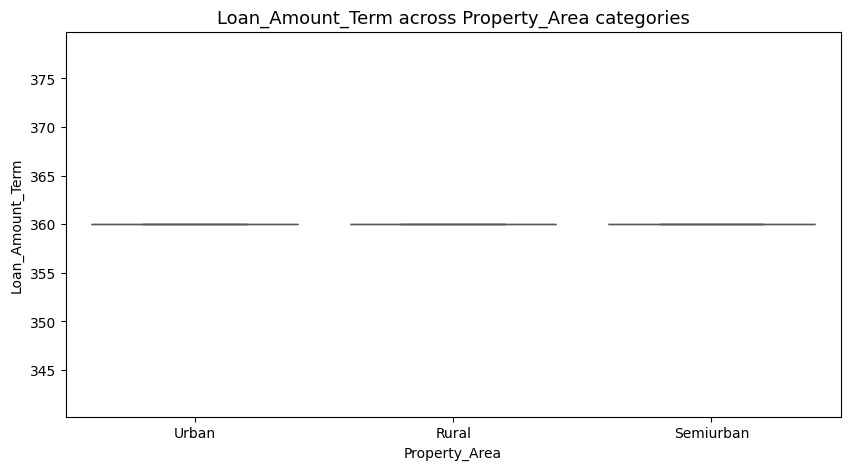

 Feature: Loan_Amount_Term vs income_rating
                mean  std    min    max
income_rating                          
High           360.0  0.0  360.0  360.0
Low            360.0  0.0  360.0  360.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


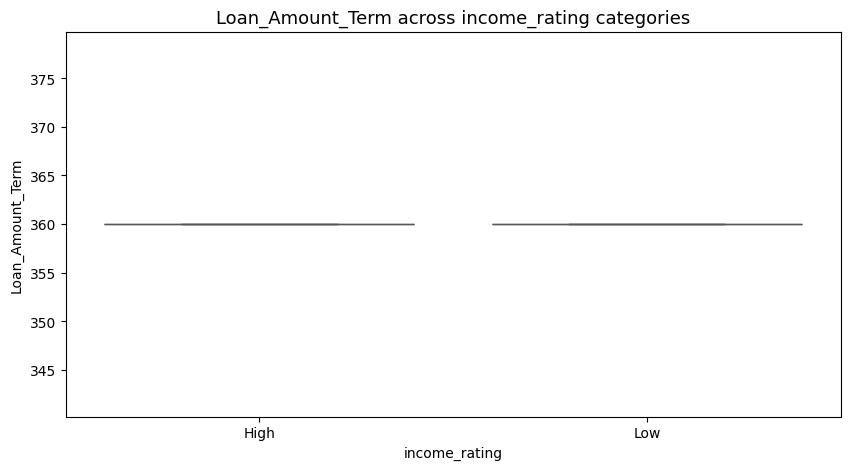

 Feature: Credit_History vs Gender
            mean       std  min  max
Gender                              
Female  0.858491  0.350202  0.0  1.0
Male    0.871520  0.334982  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


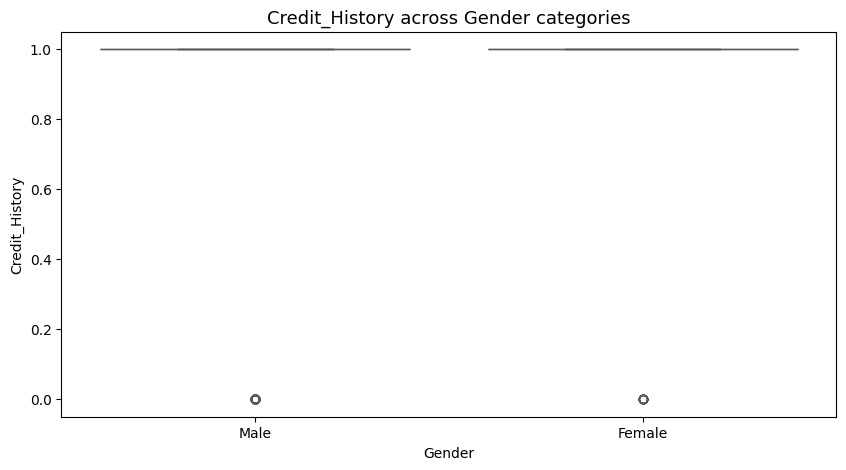

 Feature: Credit_History vs Married
             mean       std  min  max
Married                              
No       0.860697  0.347128  0.0  1.0
Yes      0.873656  0.332684  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


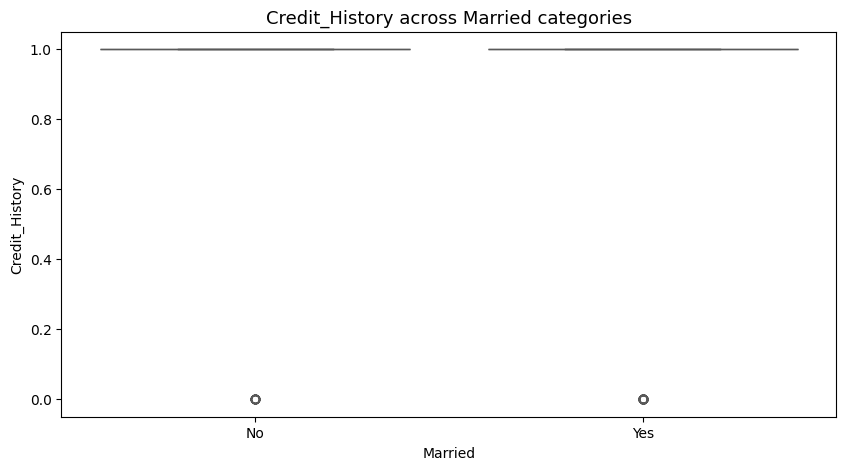

 Feature: Credit_History vs Education
                  mean       std  min  max
Education                                 
Graduate      0.877778  0.327907  0.0  1.0
Not Graduate  0.837398  0.370511  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


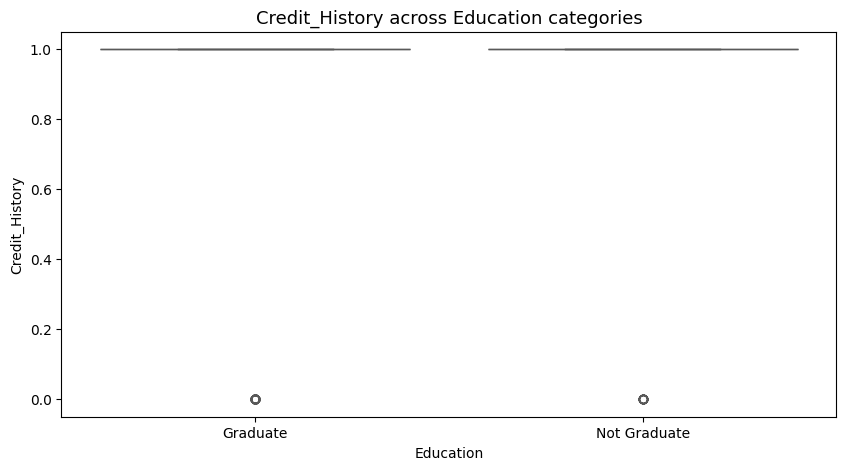

 Feature: Credit_History vs Self_Employed
                   mean       std  min  max
Self_Employed                              
No             0.873494  0.332753  0.0  1.0
Yes            0.840000  0.369075  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


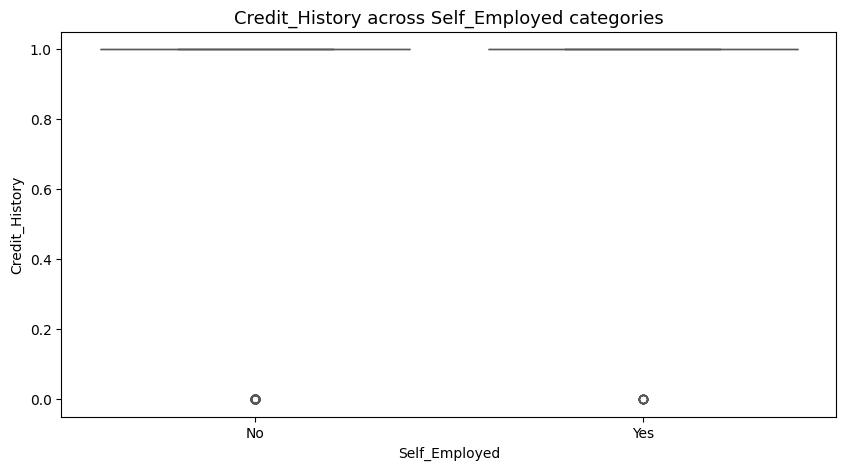

 Feature: Credit_History vs Property_Area
                   mean       std  min  max
Property_Area                              
Rural          0.857988  0.350100  0.0  1.0
Semiurban      0.885845  0.318728  0.0  1.0
Urban          0.859459  0.348490  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


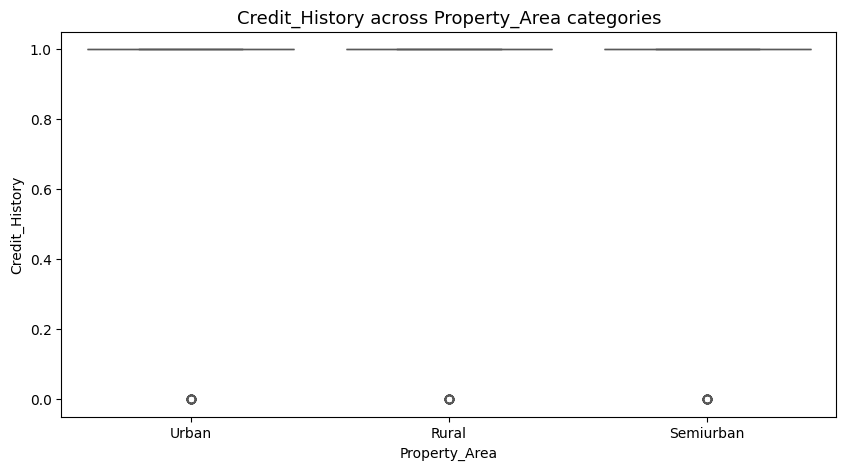

 Feature: Credit_History vs income_rating
                   mean       std  min  max
income_rating                              
High           0.877323  0.328677  0.0  1.0
Low            0.861842  0.345635  0.0  1.0



C:\Users\USER\AppData\Local\Temp\ipykernel_17788\2859194430.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=feature, data=df, palette='Set2')


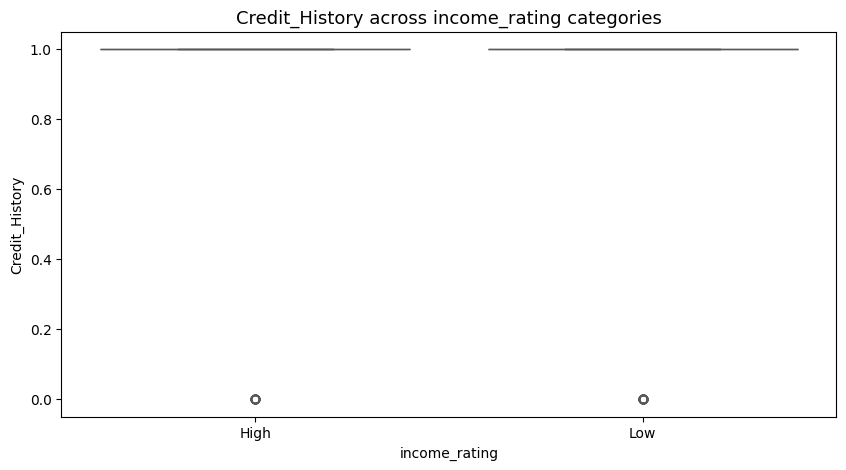

In [735]:
for num_col in num_features:
    for cat_col in cat_features:
        if cat_col == "Loan_Status":
            continue
        bivariate_num_cat(df, num_col, cat_col)



## Trivariate Analysis

In [742]:
def trivariate_plot(df, x_col, y_col, hue_col):
    """
    Visualizes the relationship between two numeric variables
    with a third categorical variable shown by color (hue).
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataset.
    x_col : str
        The first numeric feature (x-axis).
    y_col : str
        The second numeric feature (y-axis).
    hue_col : str
        The categorical feature (color grouping).
    """

    plt.figure(figsize=(8, 6))
    sns.lmplot(
        data=df, 
        x=x_col, 
        y=y_col, 
        hue=hue_col, 
        height=6, 
        aspect=1.2, 
        scatter_kws={'alpha':0.6}, 
        line_kws={'linewidth':2}
    )
    plt.title(f"{y_col} vs {x_col} by {hue_col}", fontsize=13)
    plt.xlabel(x_col, fontsize=11)
    plt.ylabel(y_col, fontsize=11)
    plt.grid(alpha=0.3)
    plt.show()


<Figure size 800x600 with 0 Axes>

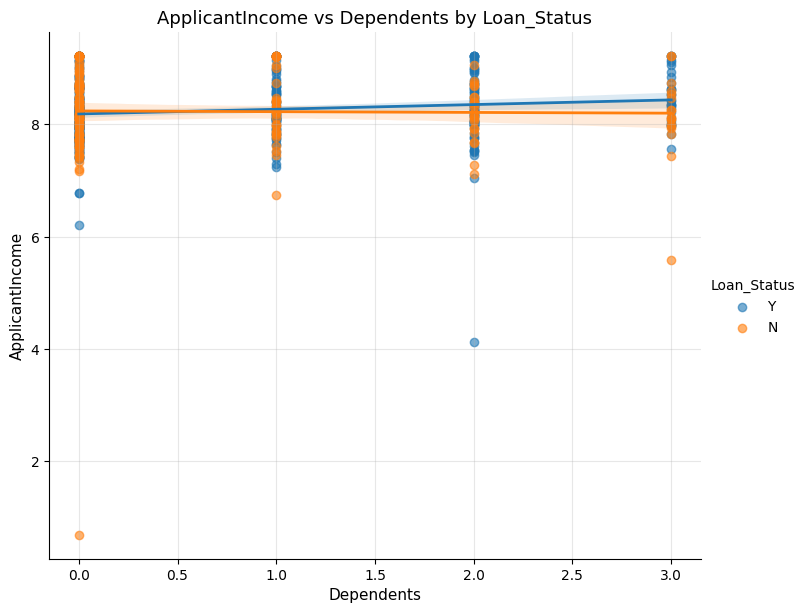

<Figure size 800x600 with 0 Axes>

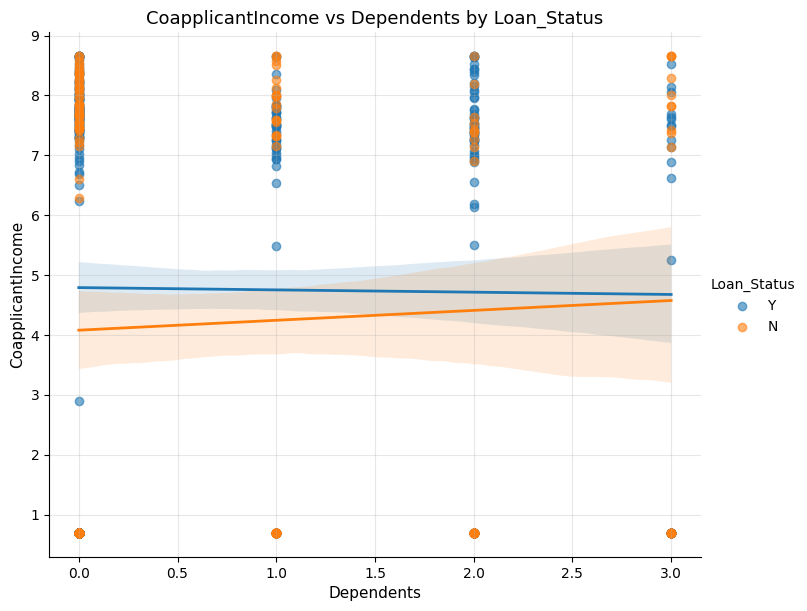

<Figure size 800x600 with 0 Axes>

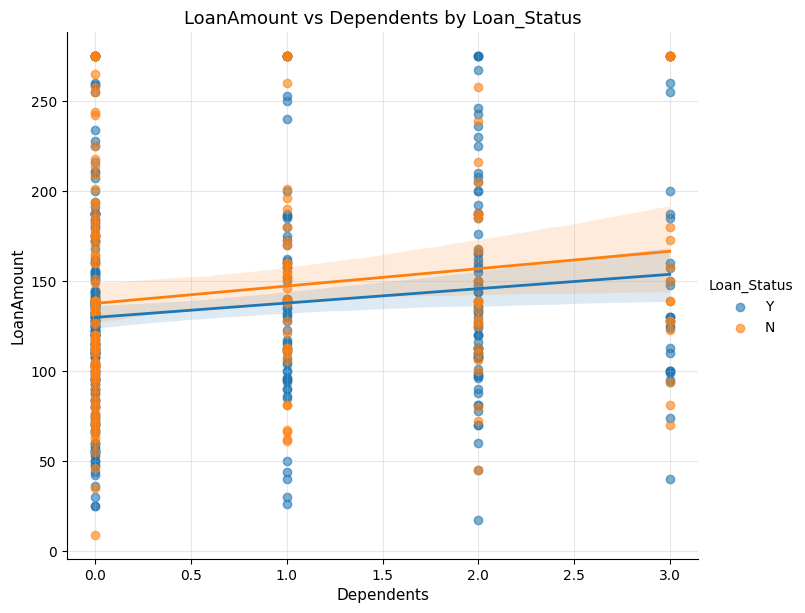

<Figure size 800x600 with 0 Axes>

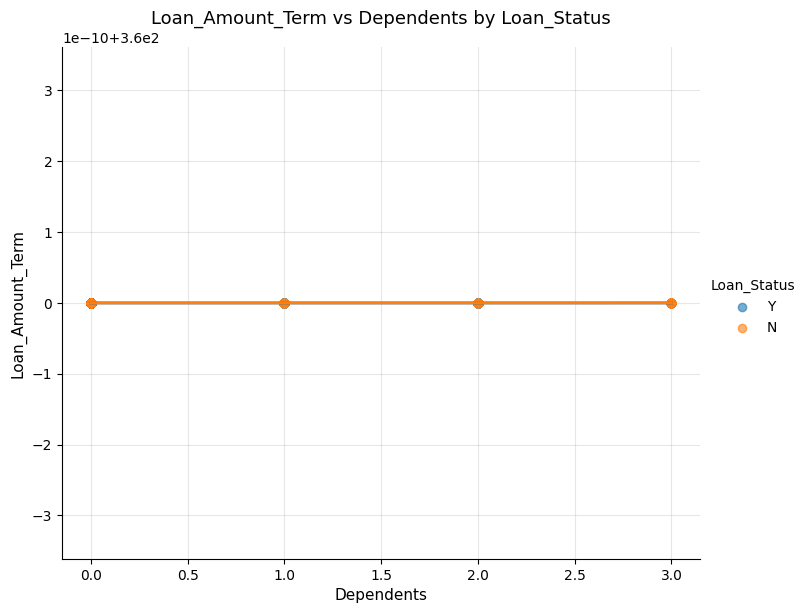

<Figure size 800x600 with 0 Axes>

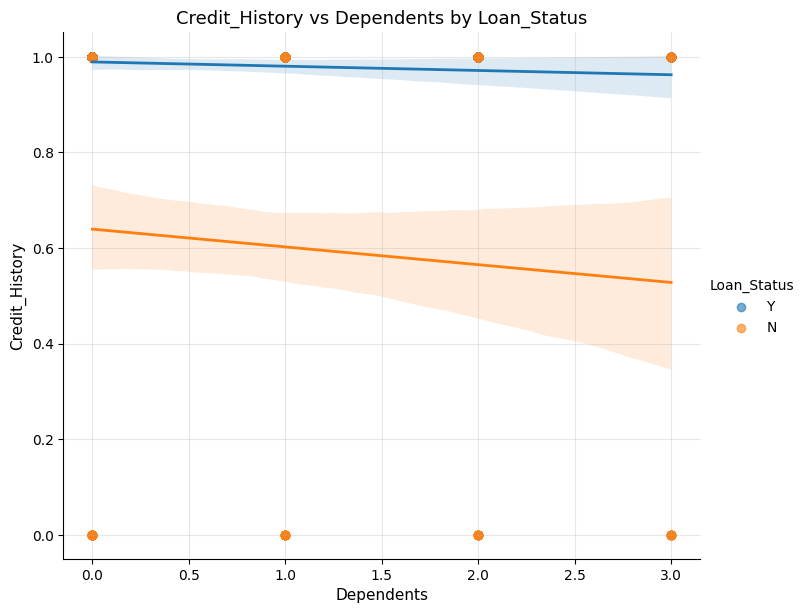

<Figure size 800x600 with 0 Axes>

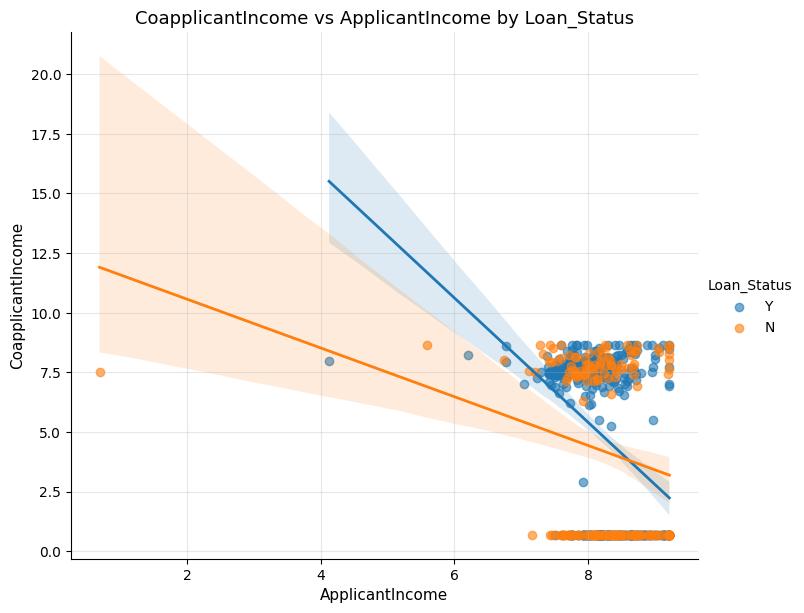

<Figure size 800x600 with 0 Axes>

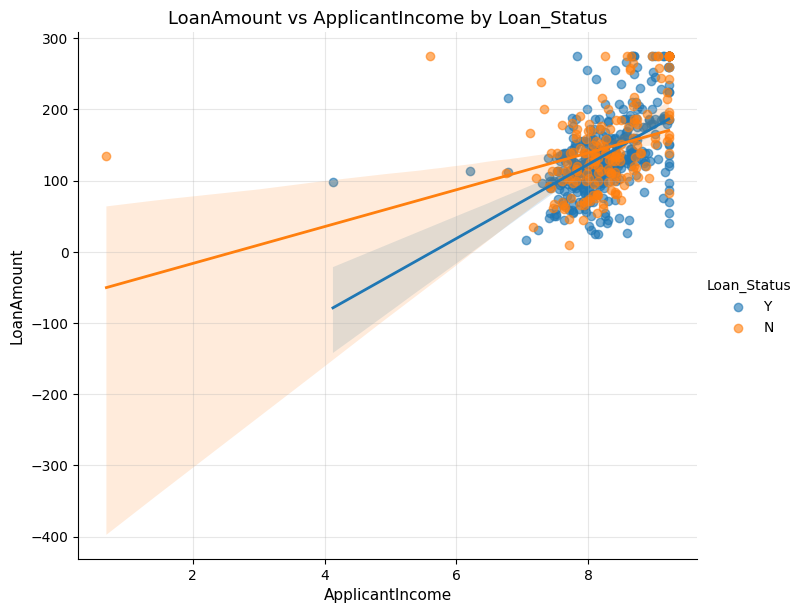

<Figure size 800x600 with 0 Axes>

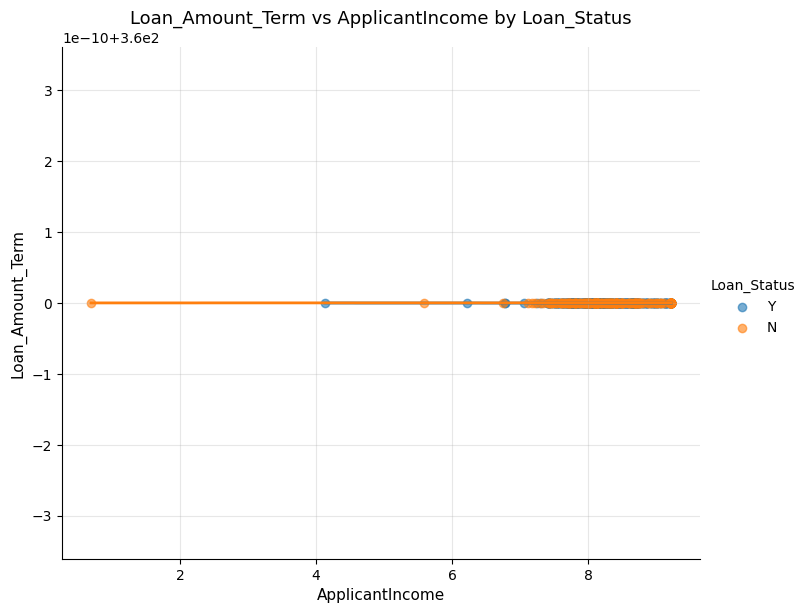

<Figure size 800x600 with 0 Axes>

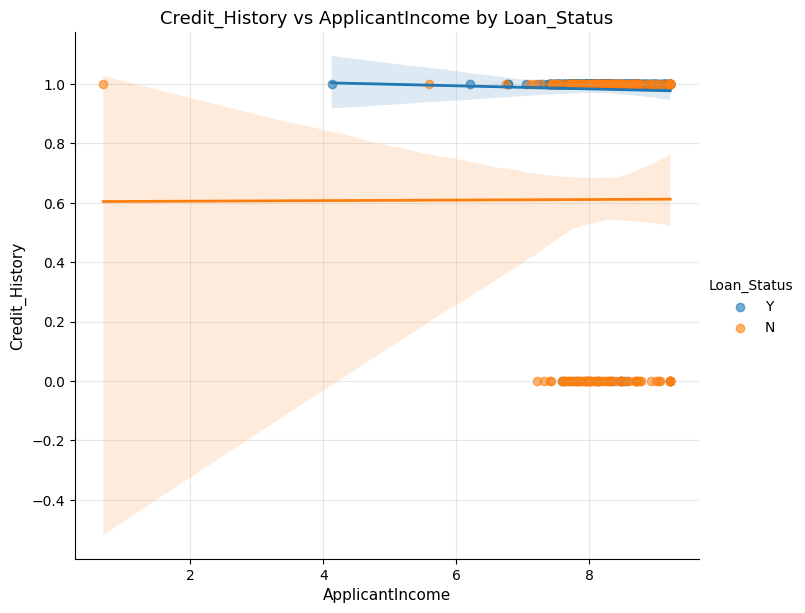

<Figure size 800x600 with 0 Axes>

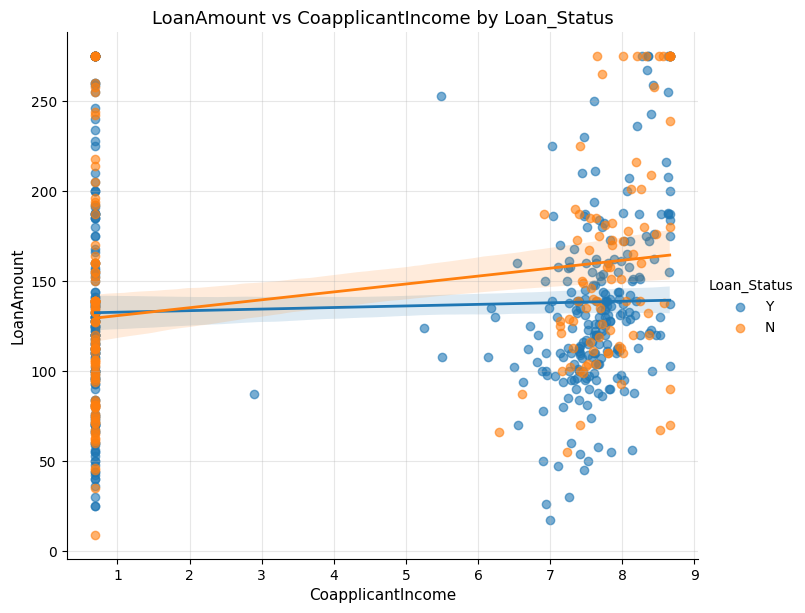

<Figure size 800x600 with 0 Axes>

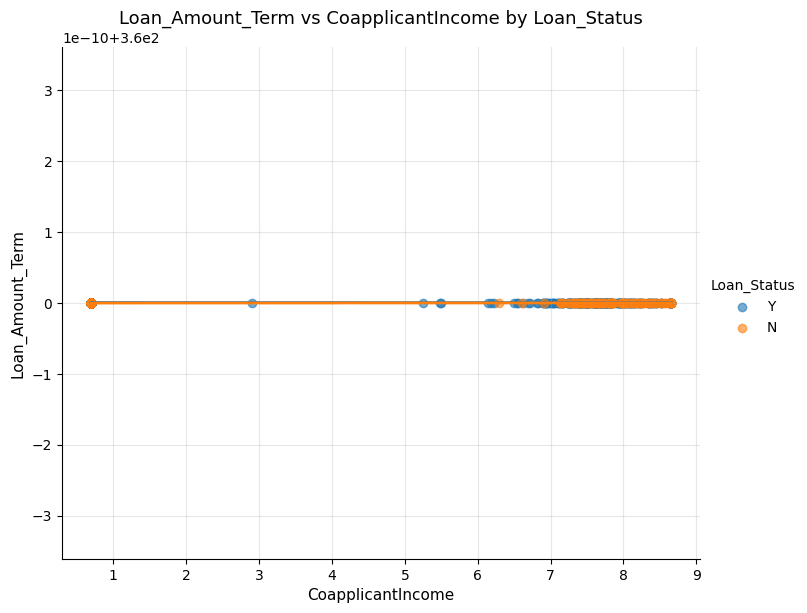

<Figure size 800x600 with 0 Axes>

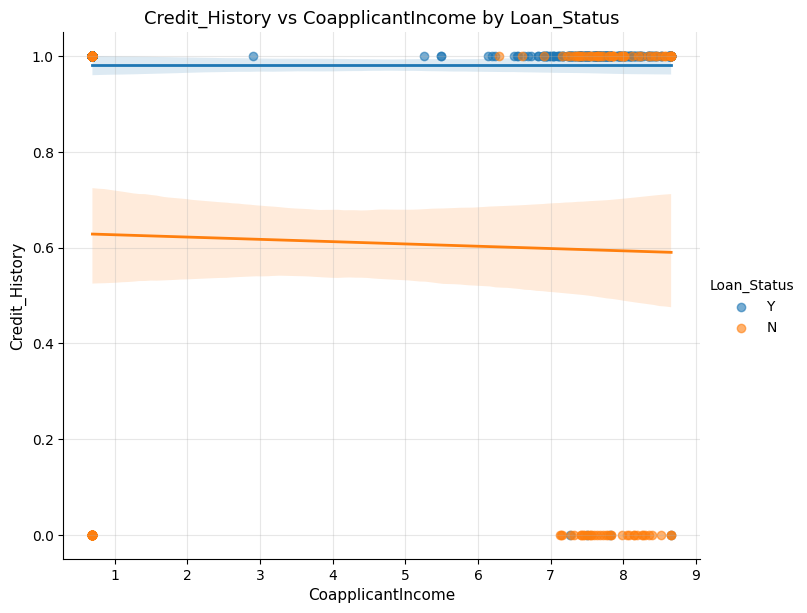

<Figure size 800x600 with 0 Axes>

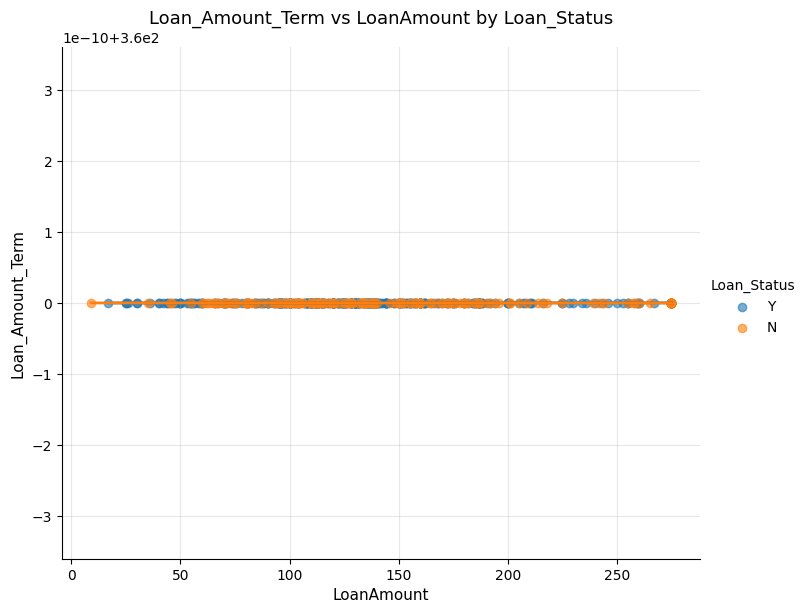

<Figure size 800x600 with 0 Axes>

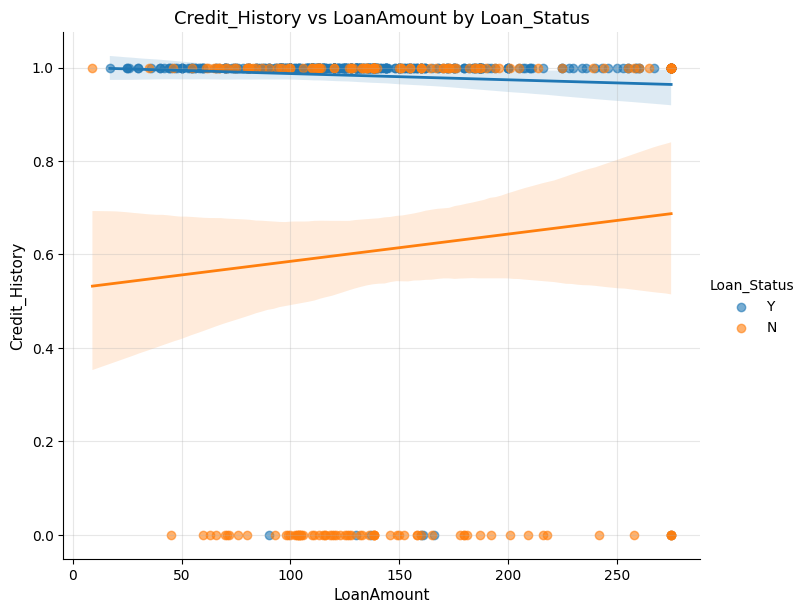

<Figure size 800x600 with 0 Axes>

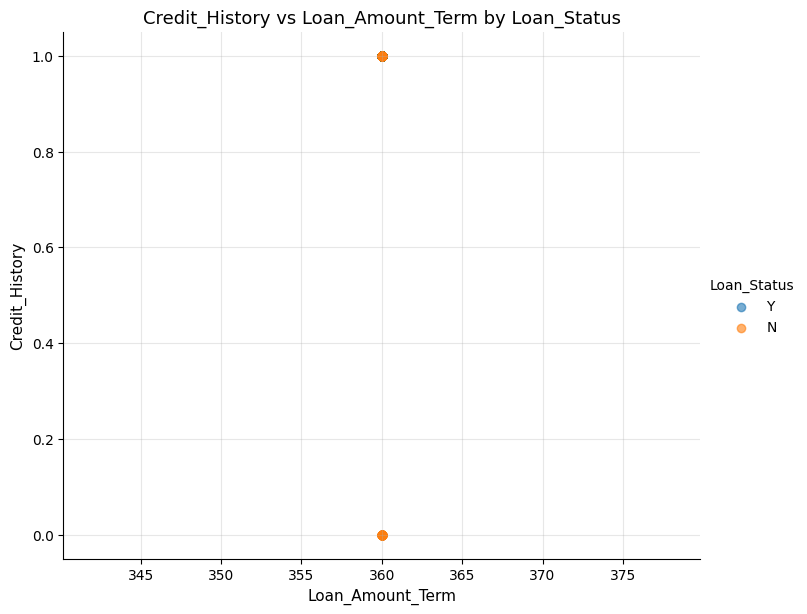

In [747]:
for i, feature1 in enumerate(num_features):
    for j, feature2 in enumerate(num_features):
        if j <= i:
            continue  # avoids duplicates and same feature pairing
        trivariate_plot(df, feature1, feature2, "Loan_Status")


## Grouped Summary

In [779]:
def num_grouped_summary(df):
    """
    Computes summary statistics grouped by wine quality.
    """
    summary = df.groupby('Loan_Status').mean(numeric_only=True).round(2)
    return summary


def cat_grouped_summary(df):
    """
    Computes percentage distribution of categorical features grouped by Loan_Status
    (similar to numeric grouped summary format).
    """
    cat_cols = df.select_dtypes(include='object').columns.drop('Loan_Status')

    summary = pd.DataFrame()

    for col in cat_cols:
        # Compute % distribution for each category within Loan_Status
        temp = pd.crosstab(df[col], df['Loan_Status'], normalize='columns') * 100

        # Rename index to show which feature it belongs to (optional but clearer)
        temp.index = [f"{col}: {i}" for i in temp.index]

        # Append to the summary table
        summary = pd.concat([summary, temp])

    # Round for readability
    return summary.round(2)


In [780]:
num_grouped_summary(df.drop(columns=["Loan_ID", "loan_status_label"]))

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,
N,0.75,8.23,4.20,144.81,360.0,0.61
Y,0.77,8.25,4.76,135.91,360.0,0.98


In [782]:
cat_grouped_summary(df.drop(columns=["Loan_ID", "loan_status_label"])).T

,Gender: Female,Gender: Male,Married: No,Married: Yes,Education: Graduate,Education: Not Graduate,Self_Employed: No,Self_Employed: Yes,Property_Area: Rural,Property_Area: Semiurban,Property_Area: Urban,income_rating: High,income_rating: Low
Loan_Status,,,,,,,,,,,,,
N,20.00,80.00,42.29,57.71,74.29,25.71,85.71,14.29,36.57,28.00,35.43,49.71,50.29
Y,17.84,82.16,31.91,68.09,80.40,19.60,87.44,12.56,26.38,42.71,30.90,45.73,54.27
